# 2. Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd
import IPython.display as ipd
import librosa , librosa.display
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from yellowbrick.features import PCA
from pca import pca
from umap import UMAP
import umap.plot
%matplotlib inline

plt.style.use("default")

In [2]:
%store -r x
%store -r sr
%store -r labels
%store -r X_img_clean
%store -r X_data
%store -r y

Let's start by visualizing the wave form of our loaded sound

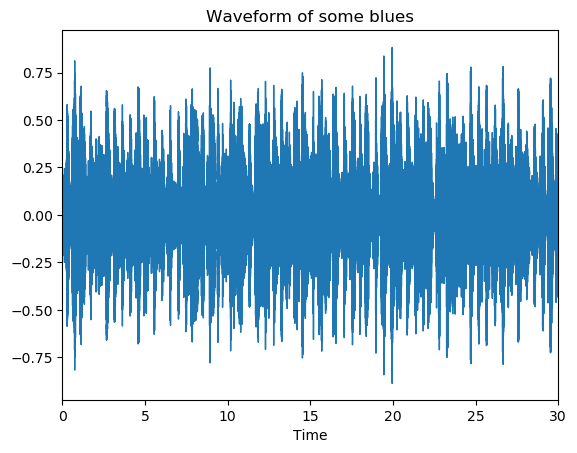

In [3]:
librosa.display.waveplot(x, sr)
plt.title("Waveform of some blues");

This is the representation of the audio file in time-domain, we see time that is 30 seconds as expected and we have amplitude on the y-axis that represent the loudness of the audio.  
We can also have the representation of the audio file in frequency-domain by applying a short time Fourier transformation :

/Users/jasonola/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.
  """Entry point for launching an IPython kernel.


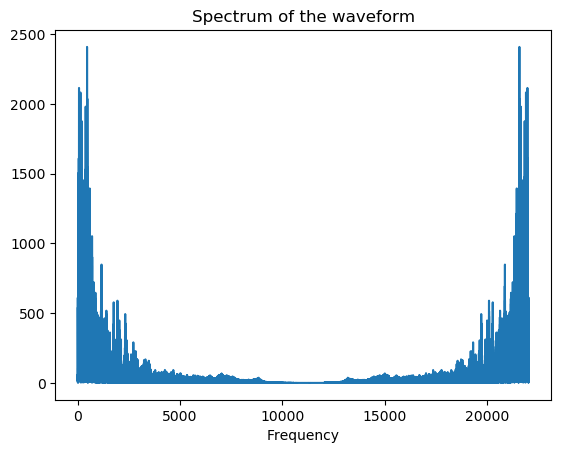

In [4]:
stft = scipy.fft(x)
stft_mag = np.absolute(stft)
f = np.linspace(0, sr, len(stft_mag))
plt.plot(f, stft_mag)
plt.xlabel('Frequency')
plt.title("Spectrum of the waveform");

It shows the magnitude of the frequencies.  
If we put time-domain and frequency-domain together we get a spectrogram. And if we mel-scale it we get a mel-spectrogram shown below, that is the same as the one we get in the image file ! Luckily we got a dataset made by someone who took the effort to put these spectrograms at our disposal.  
We select a hop length to have a overlapping between frames to prevent something called spectral leakage due to a window function. We select a power of 2, here 128 because I heard it helps for computability.

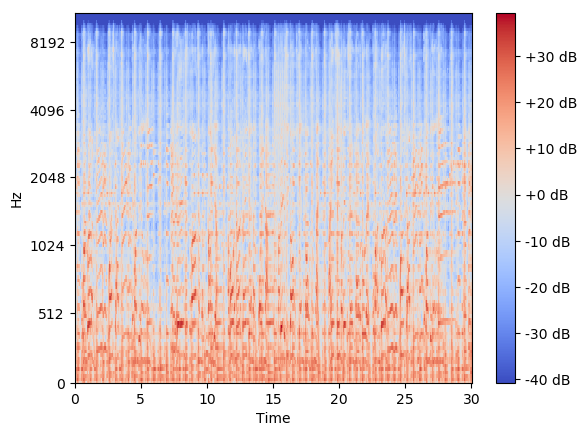

In [5]:
hop_length = 128
sp = librosa.feature.melspectrogram(x, sr=sr, n_fft=4096, hop_length=hop_length)
mel_sp = librosa.power_to_db(abs(sp))
librosa.display.specshow(mel_sp, sr=sr, hop_length=hop_length, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB');

We computed here the mel spectrogram that we actually already have in png format.

Let's now do EDA on the csv data, let's start by ploting our features against our labels in histograms

In [6]:
Xy = X_data.join(labels).groupby("label")

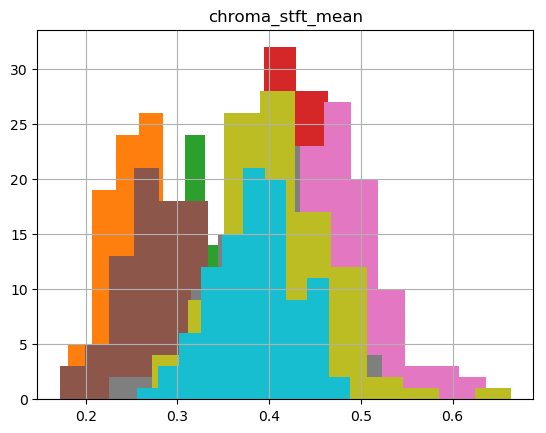

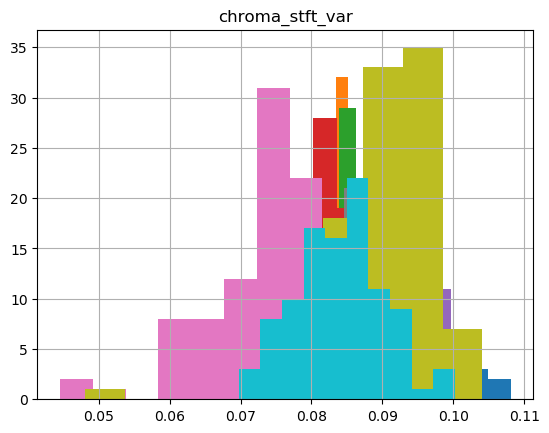

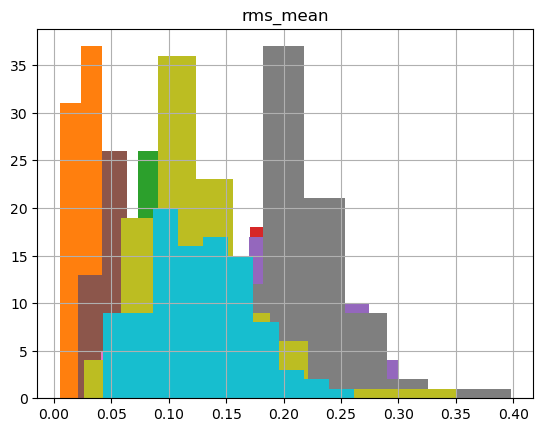

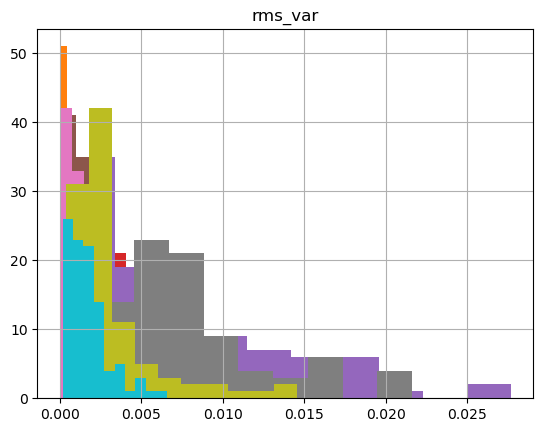

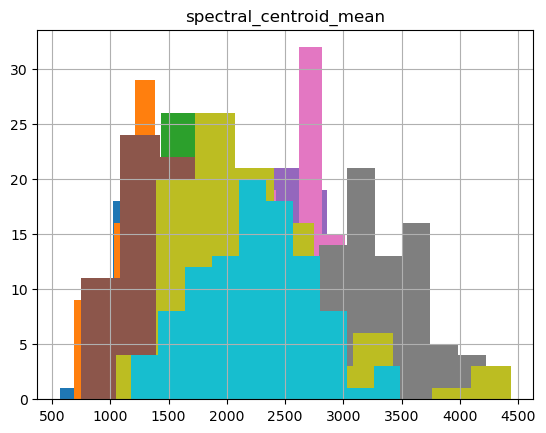

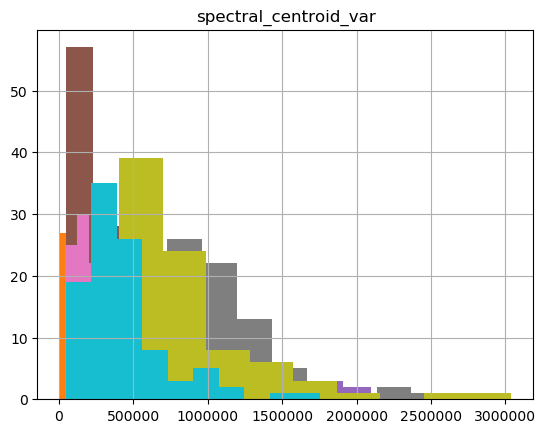

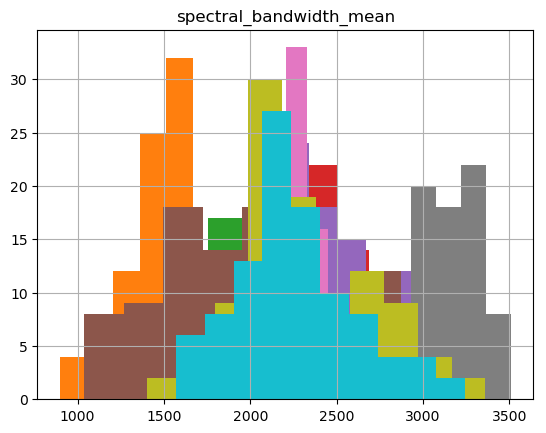

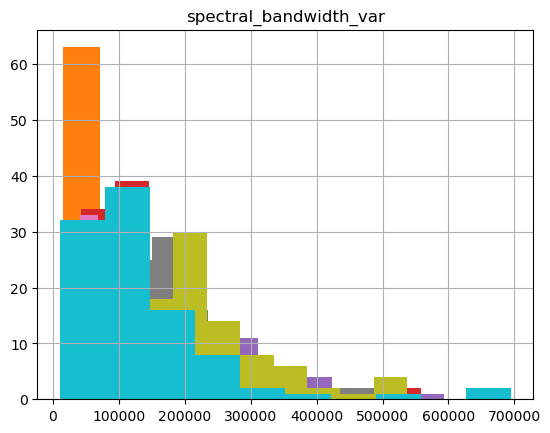

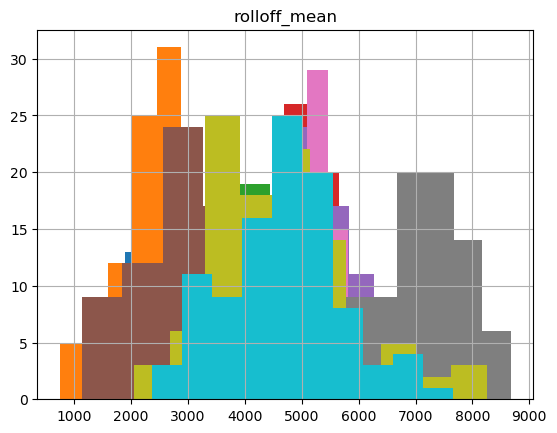

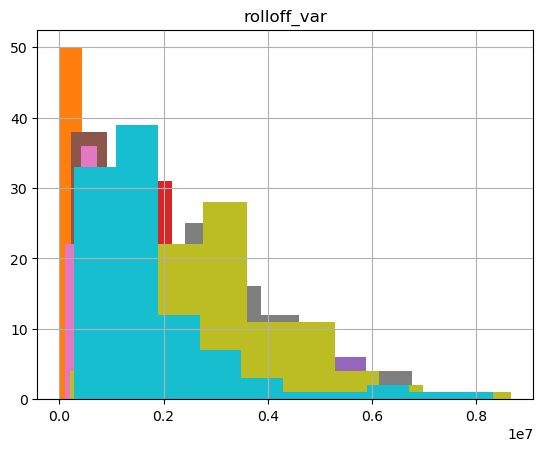

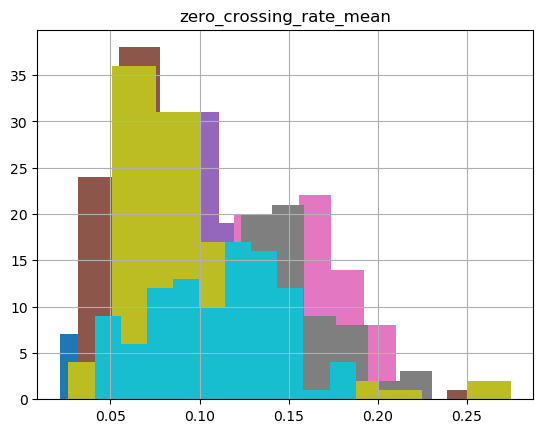

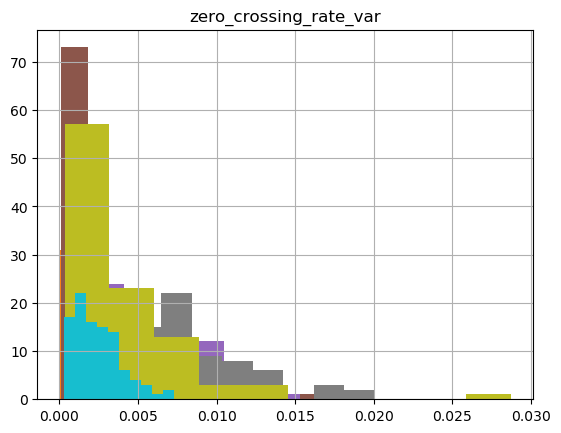

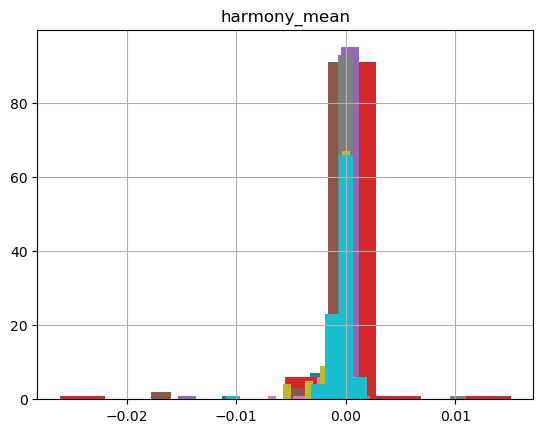

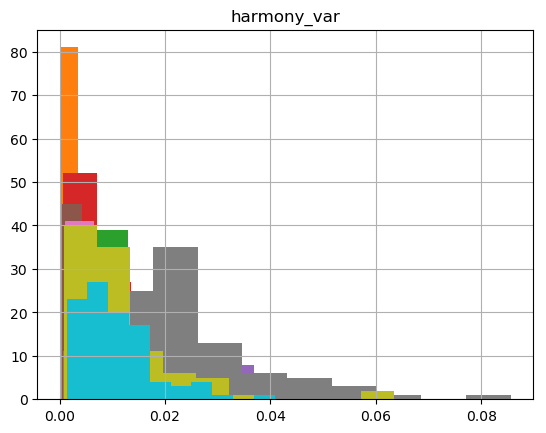

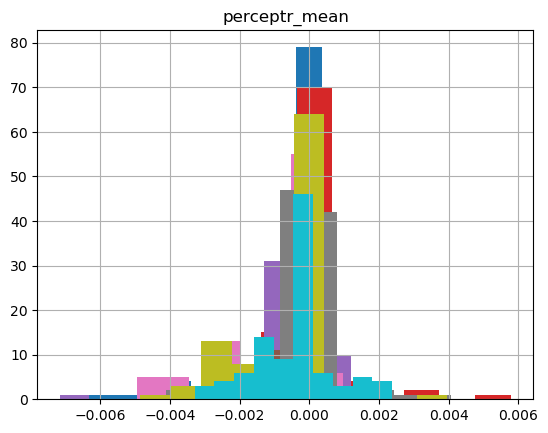

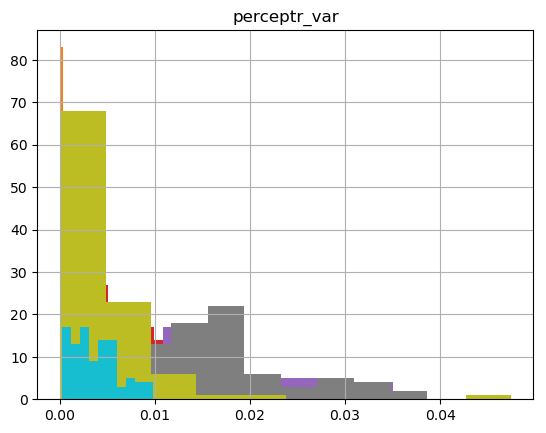

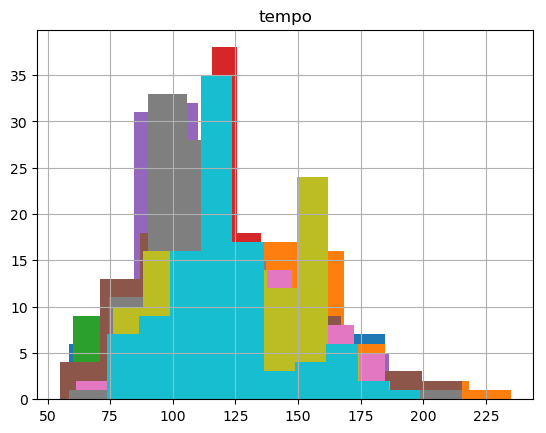

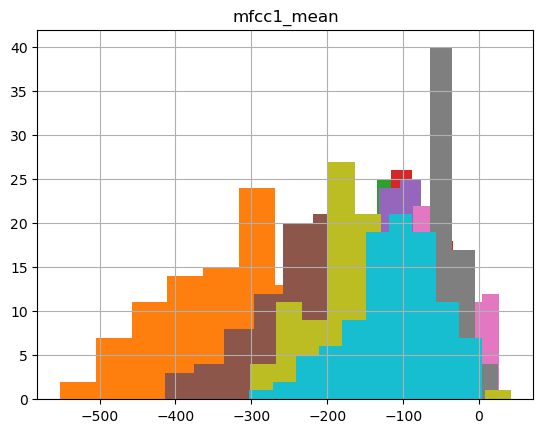

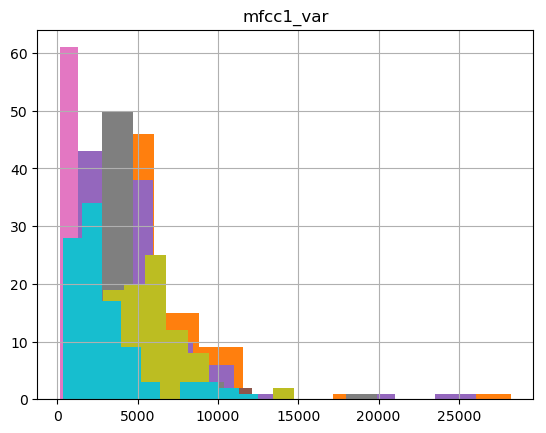

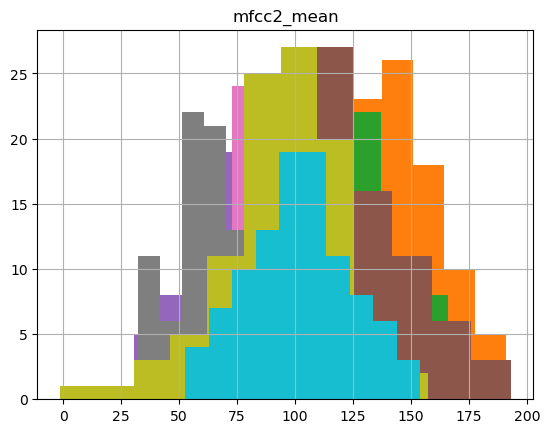

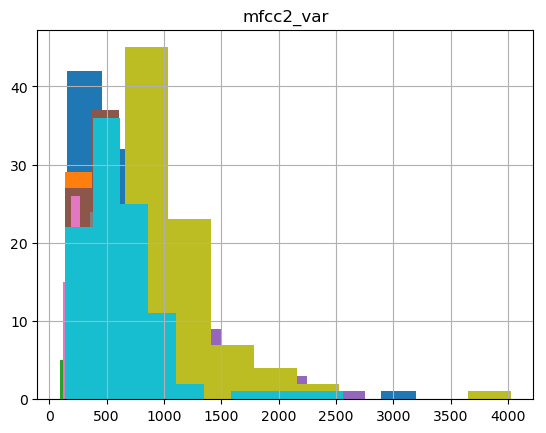

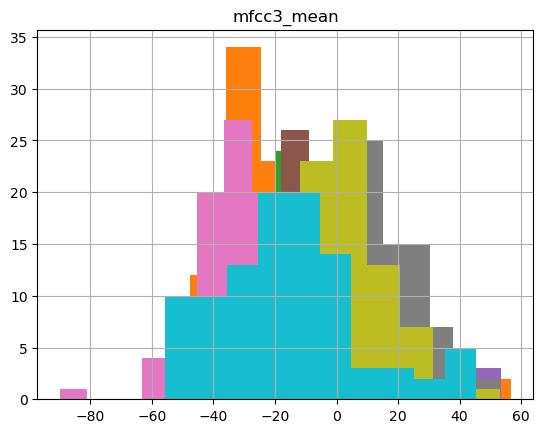

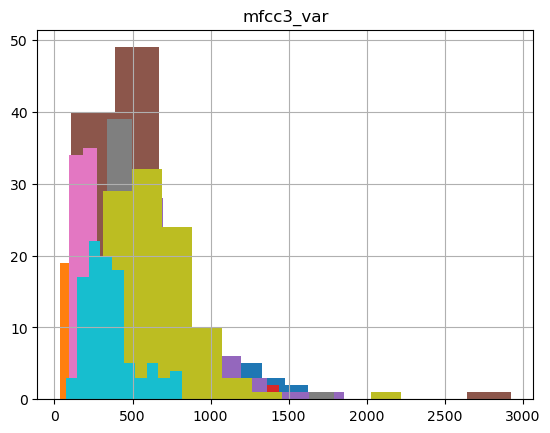

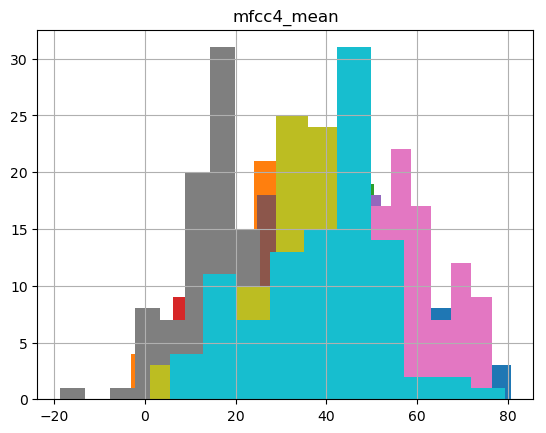

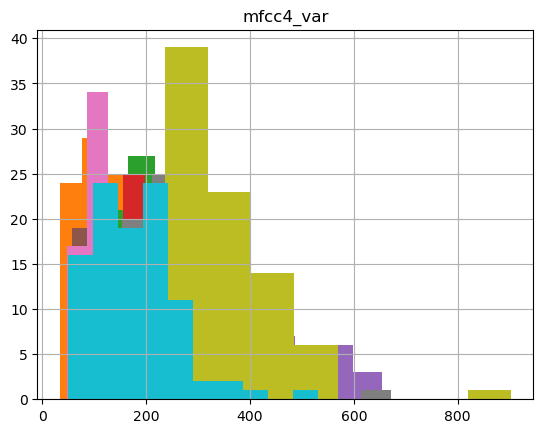

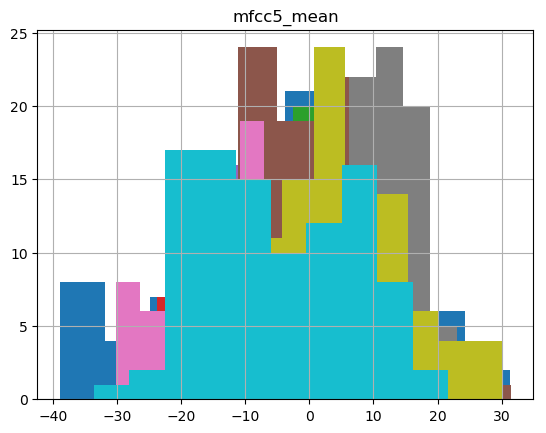

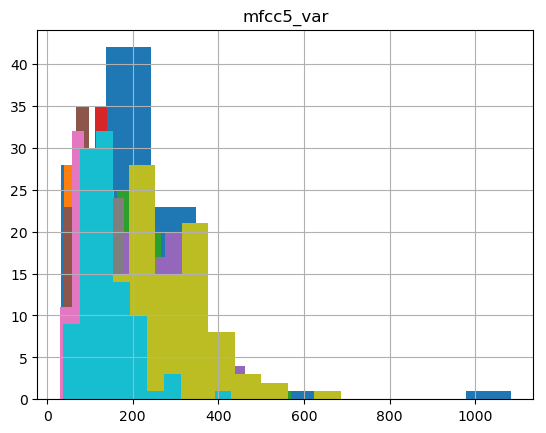

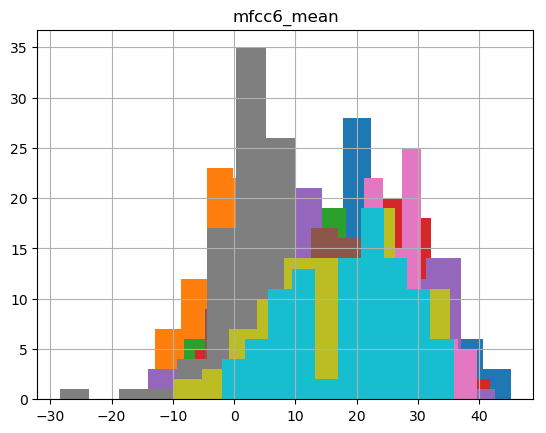

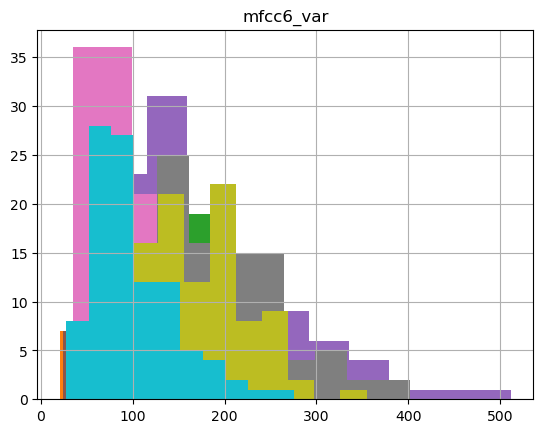

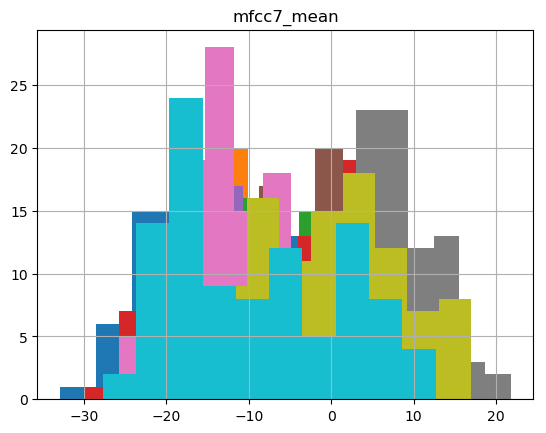

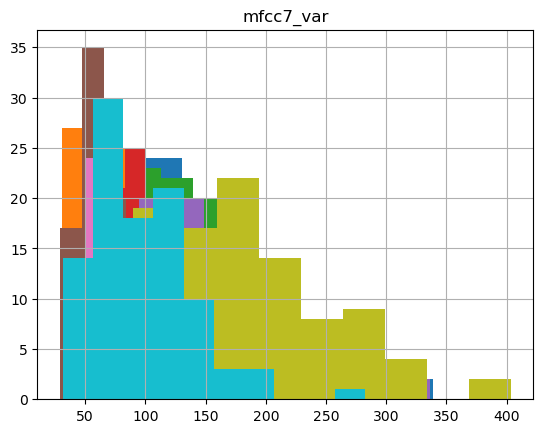

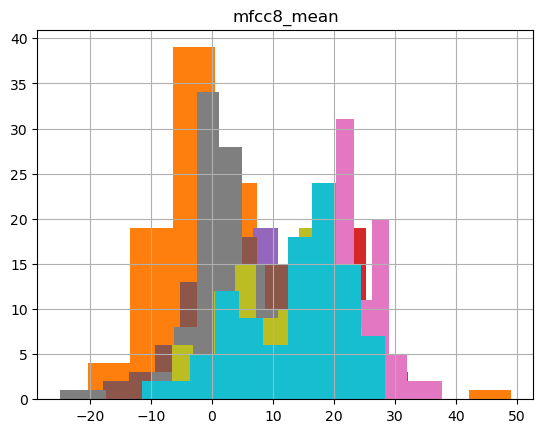

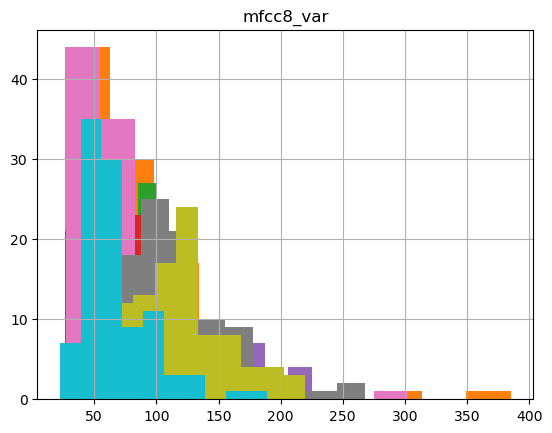

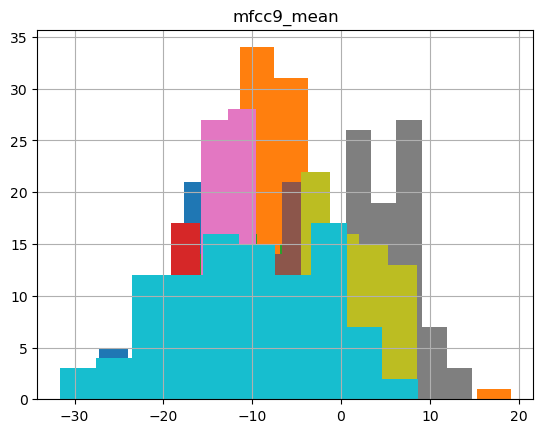

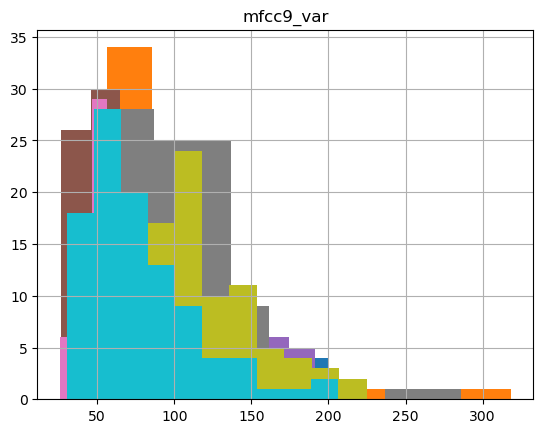

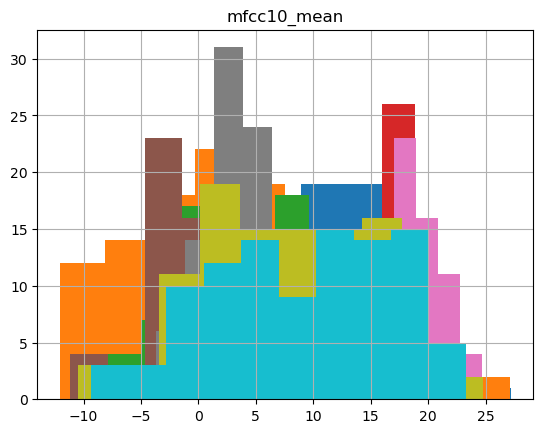

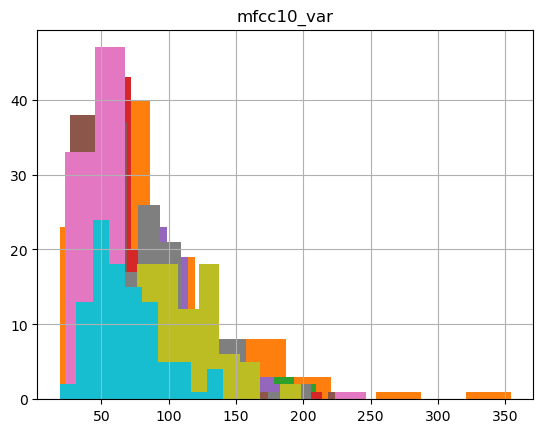

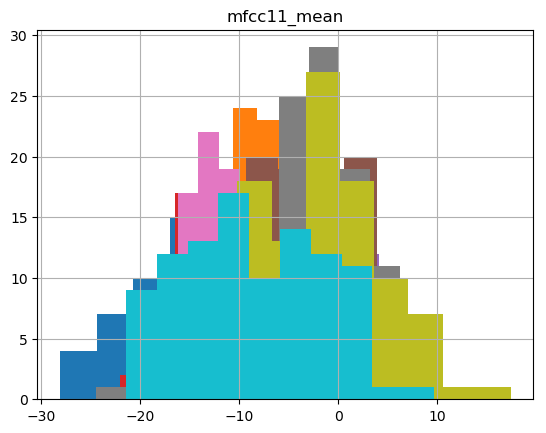

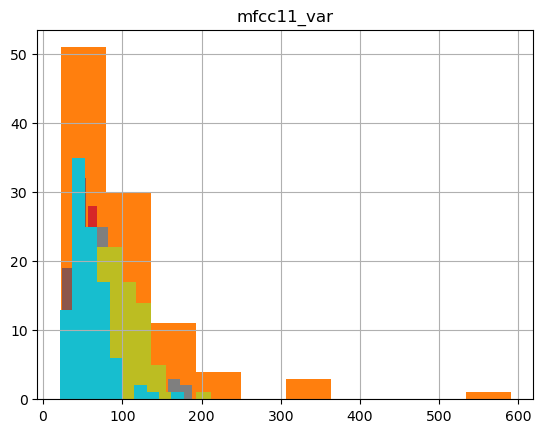

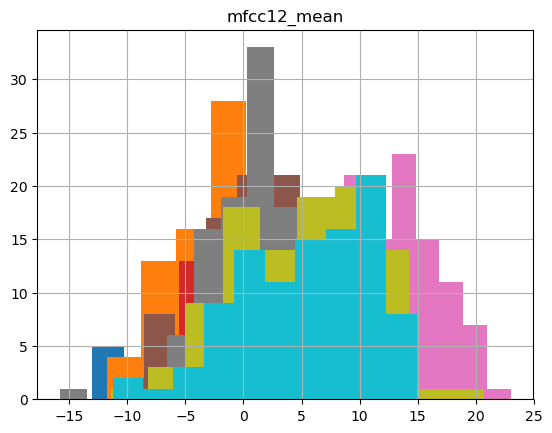

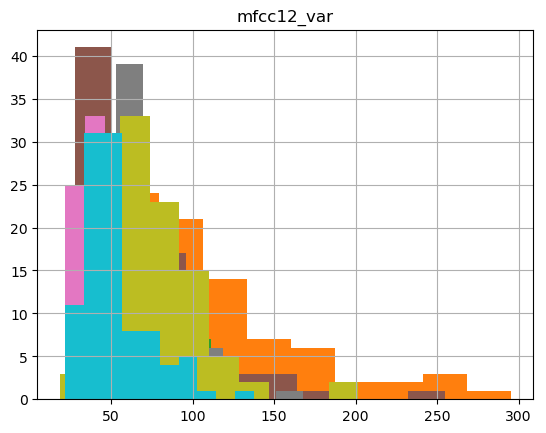

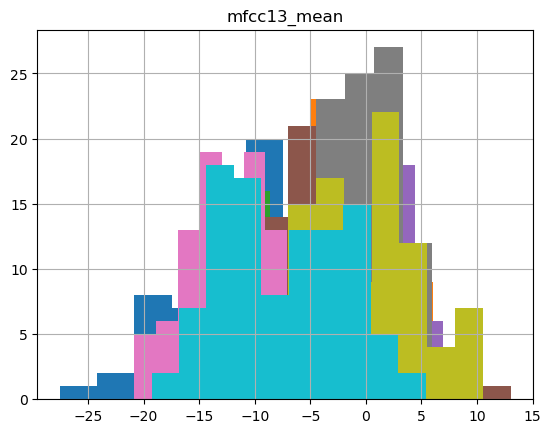

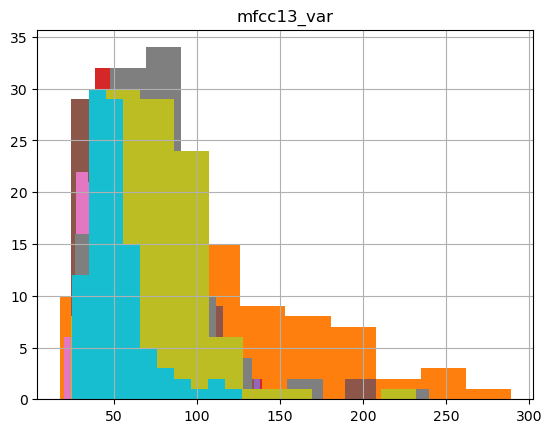

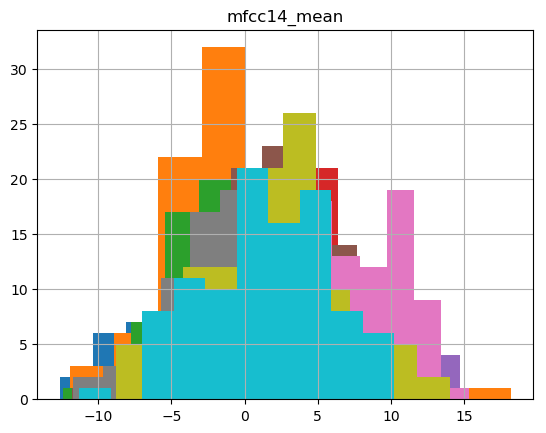

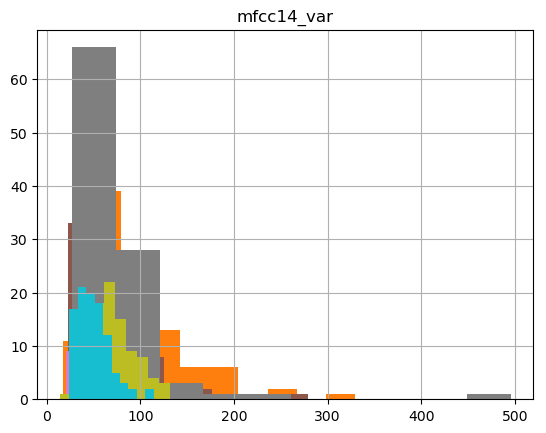

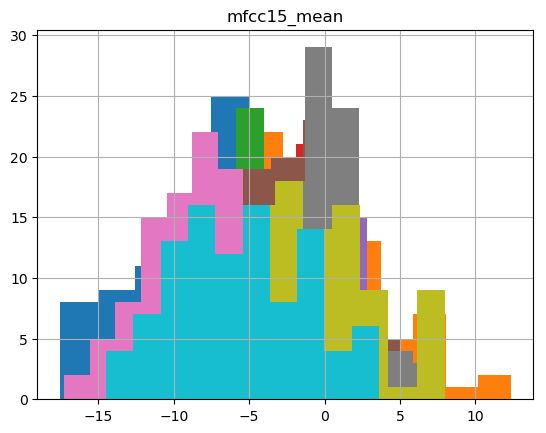

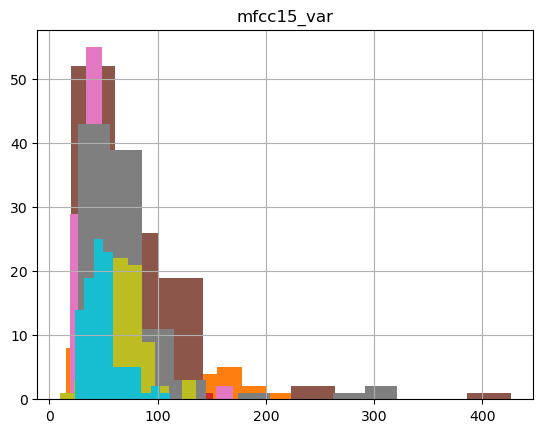

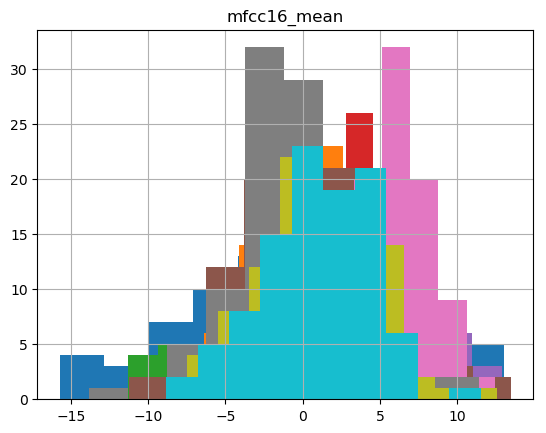

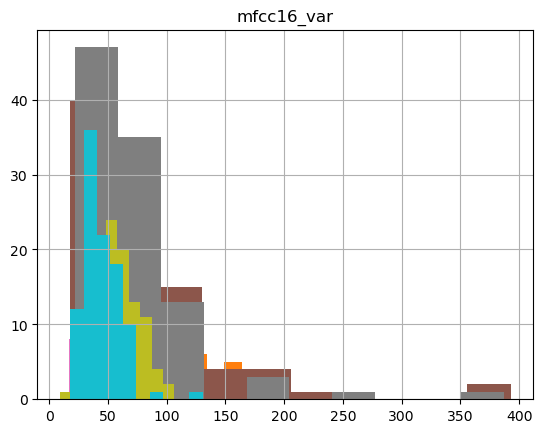

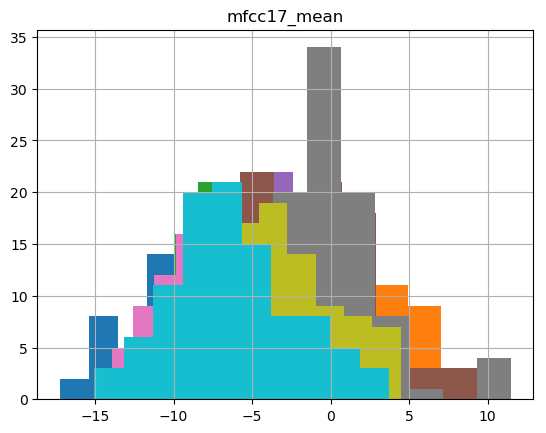

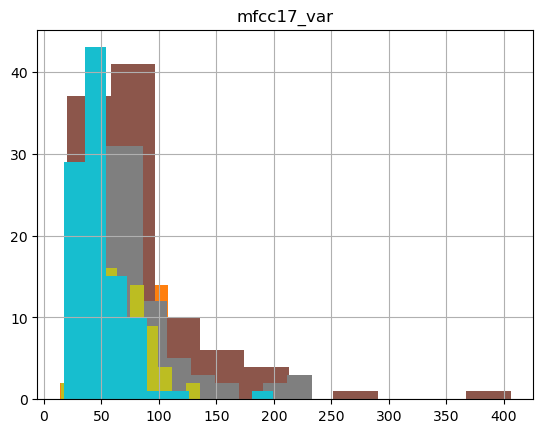

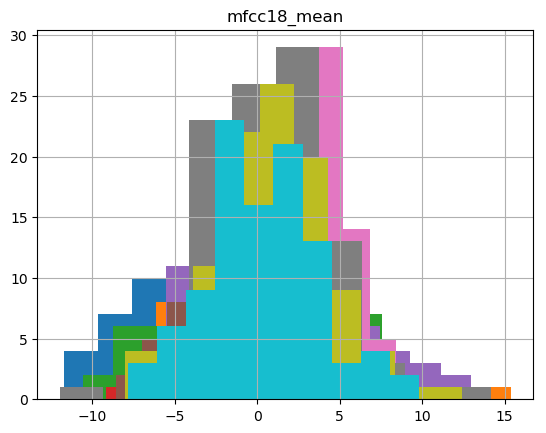

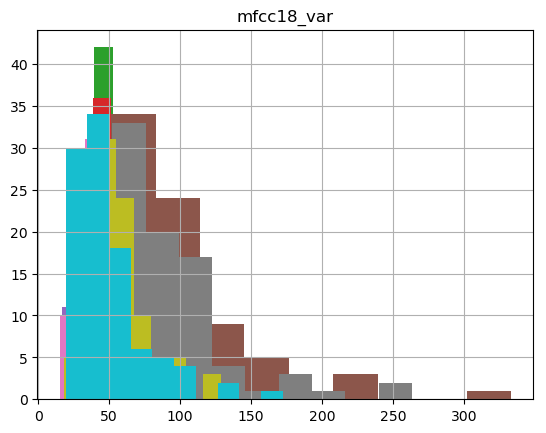

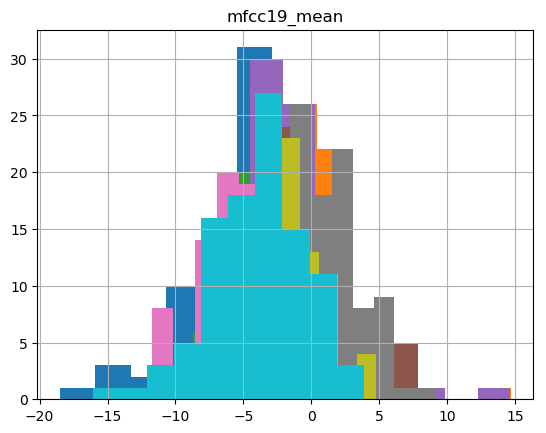

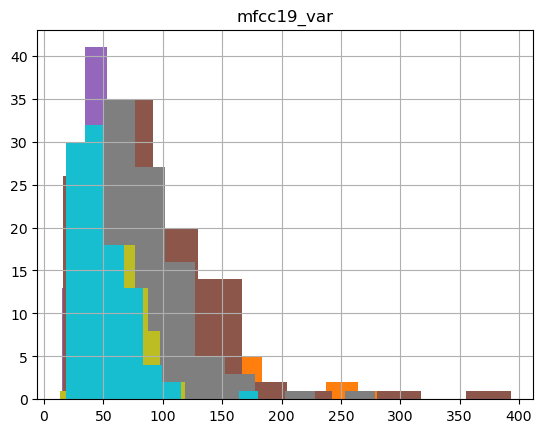

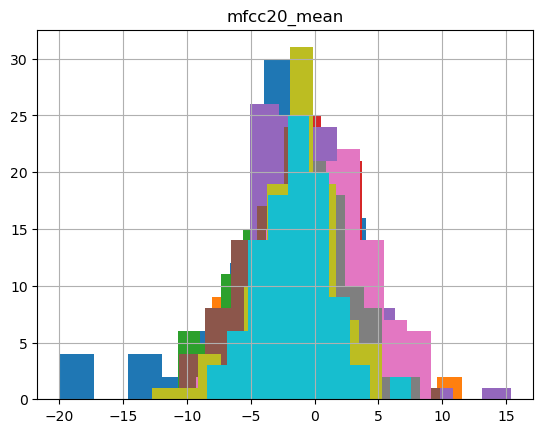

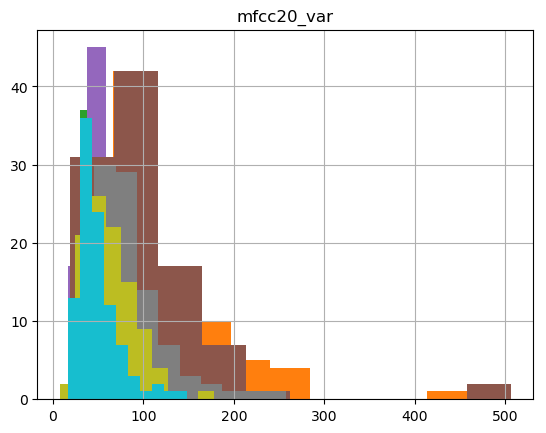

In [7]:
with plt.rc_context(rc={'figure.max_open_warning': 0}): #helps with memory
    for feat in X_data.columns:
        plt.figure()
        Xy[feat].hist()
        plt.title(feat)

Here we see different histograms by classes of the features and we see that we can have seperations of classes for some featuresvlike the rolloff mean, chroma mean or spectral means. We also see something interesting with the distribution shape, all means are normaly distributed, which make sense due to central limit theorem, however almost all variance features are skewed to the left, we need to fix this with a log function before moving ahead.

In [8]:
var_cols = [X_data.drop("tempo",axis=1).columns[i+1] for i in range(0,X_data.drop("tempo",axis=1).columns.size,2)]

In [9]:
X_data[var_cols] = np.log1p(X_data[var_cols])
Xy = X_data.join(labels).groupby("label")

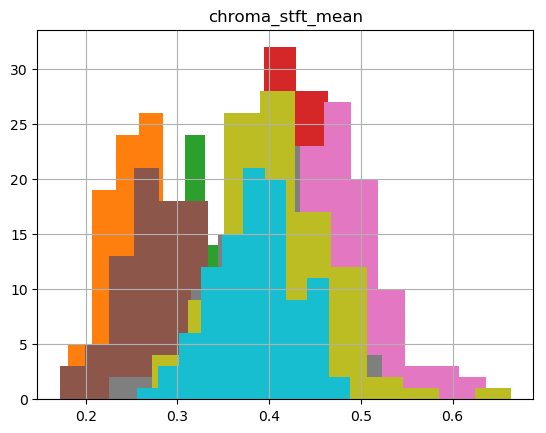

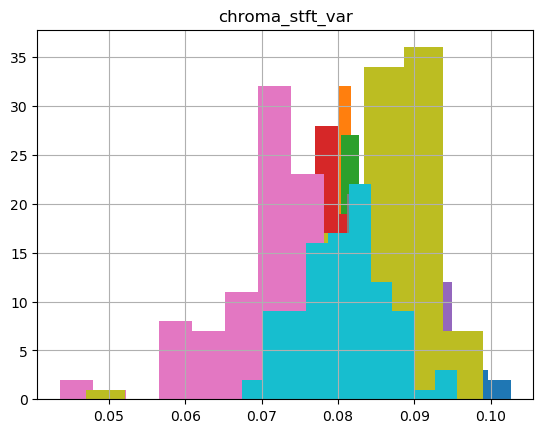

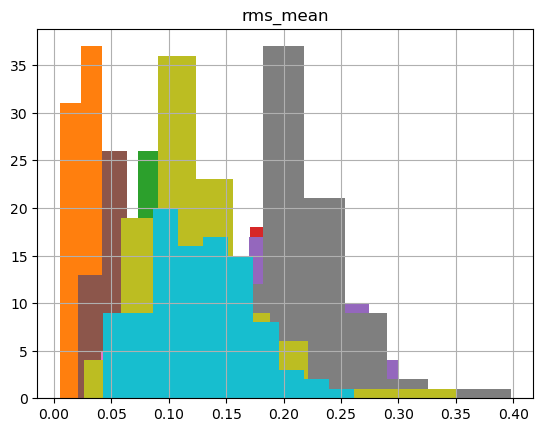

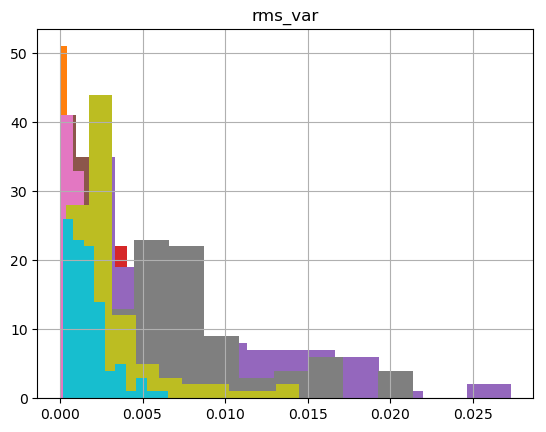

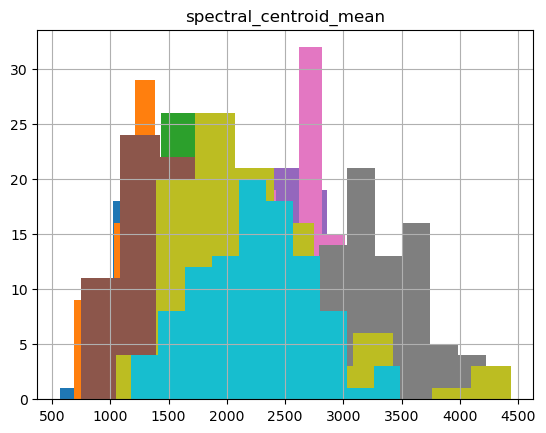

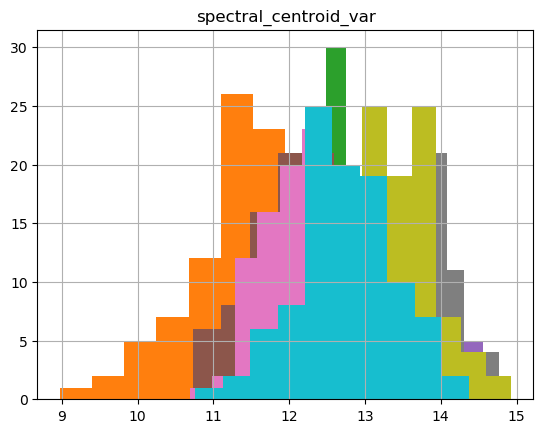

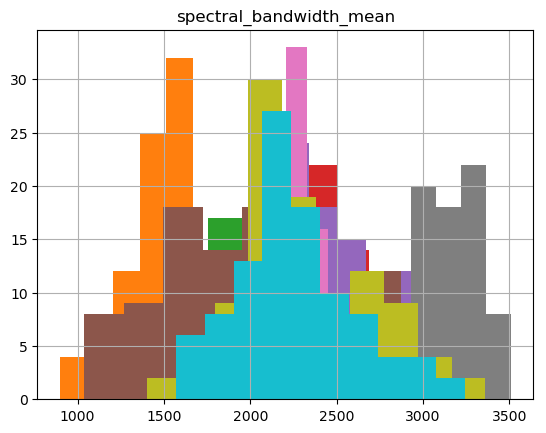

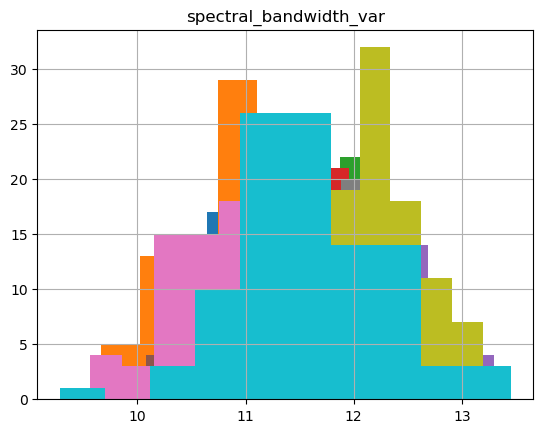

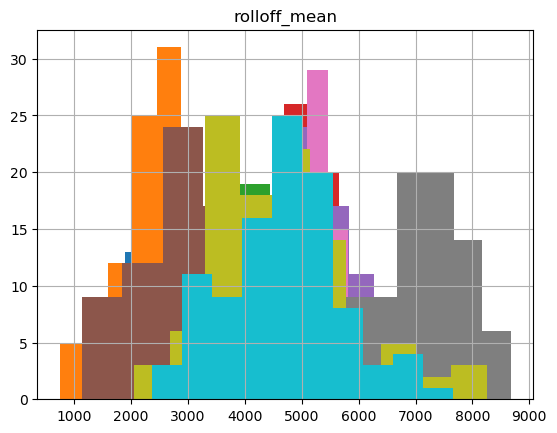

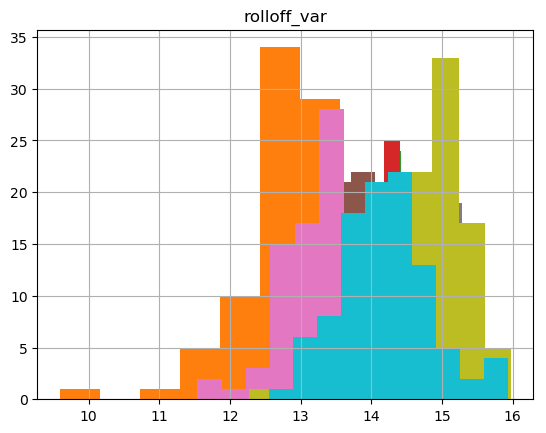

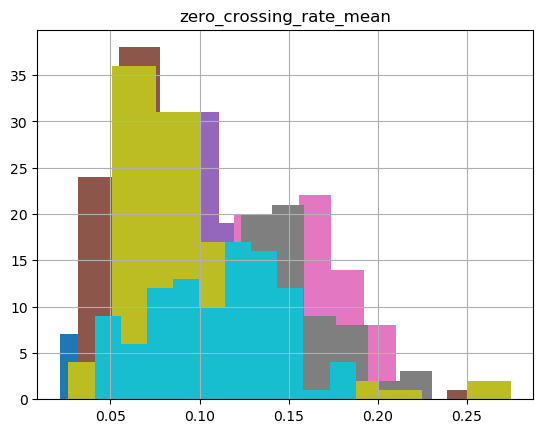

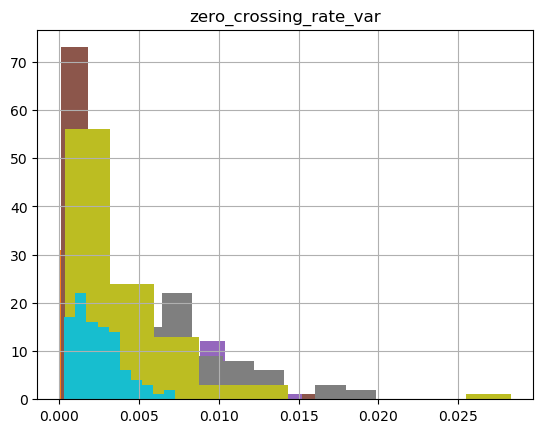

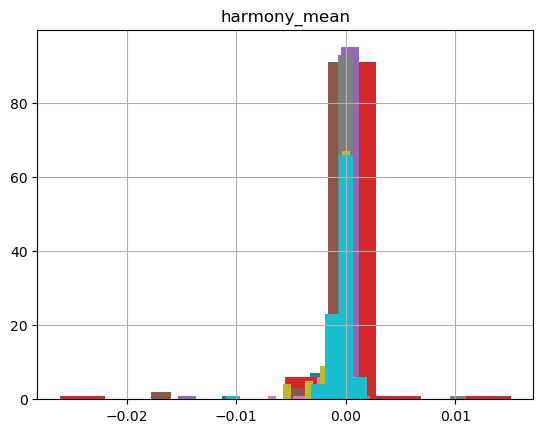

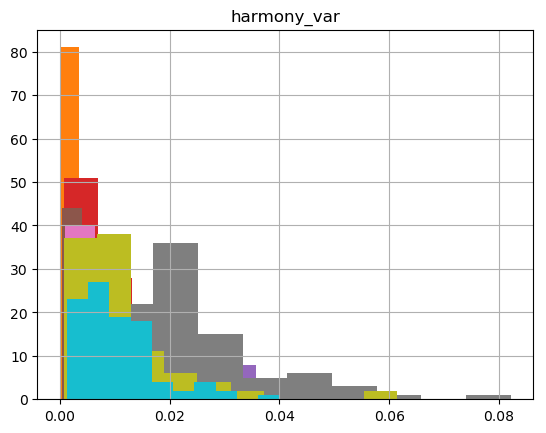

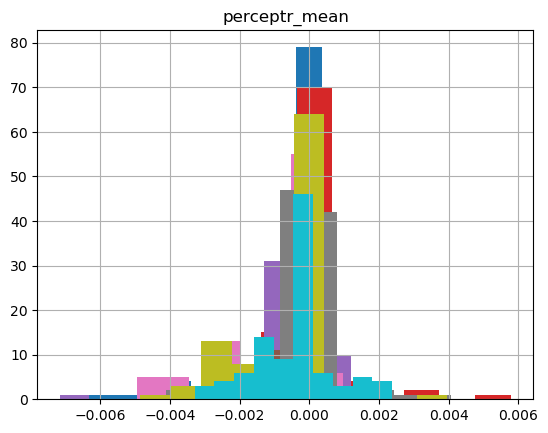

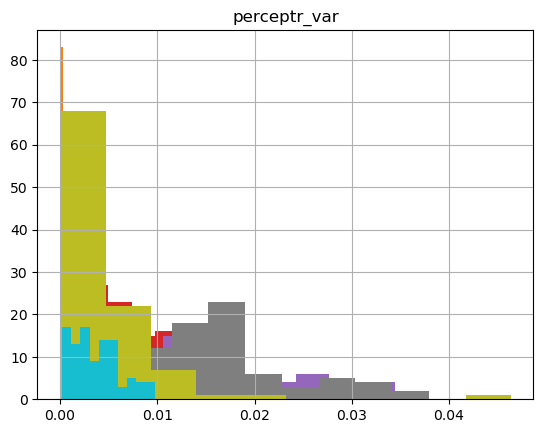

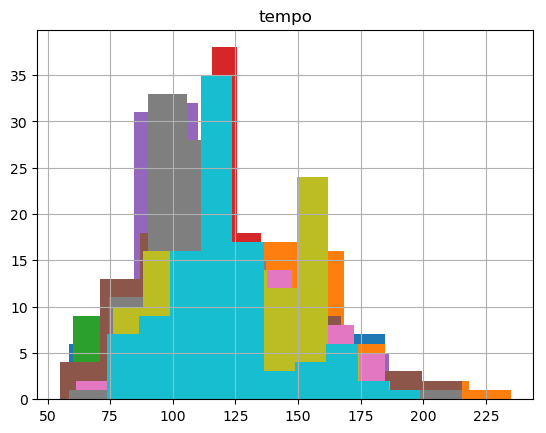

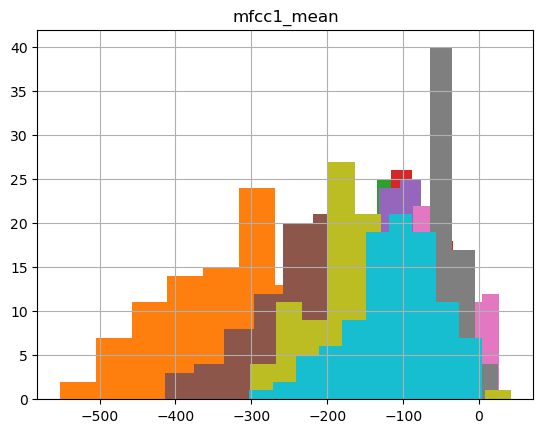

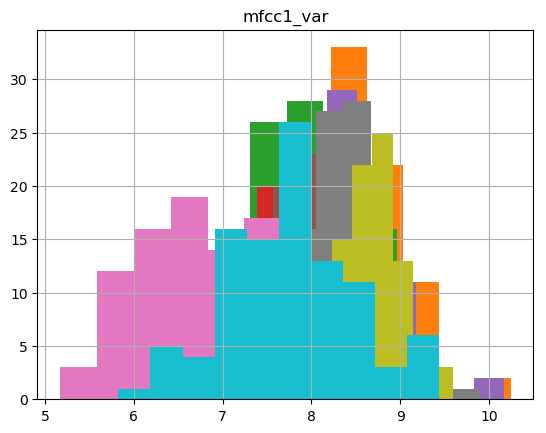

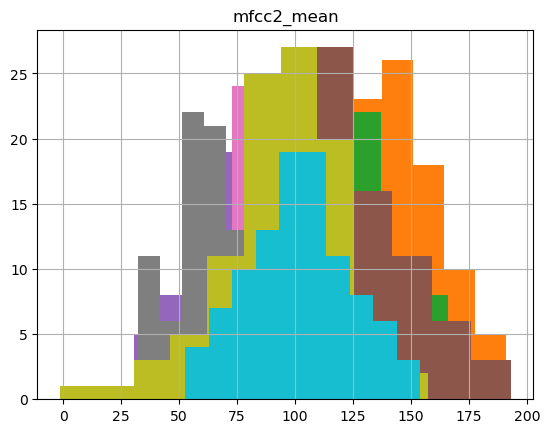

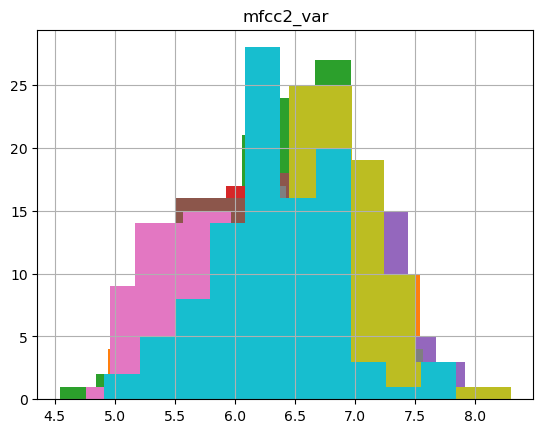

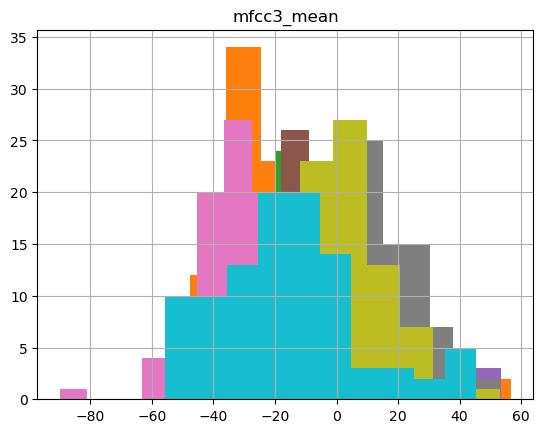

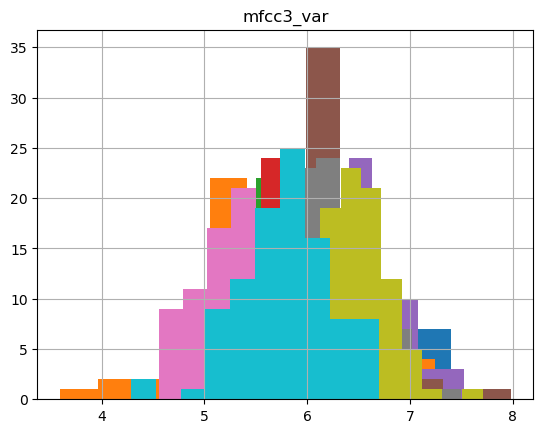

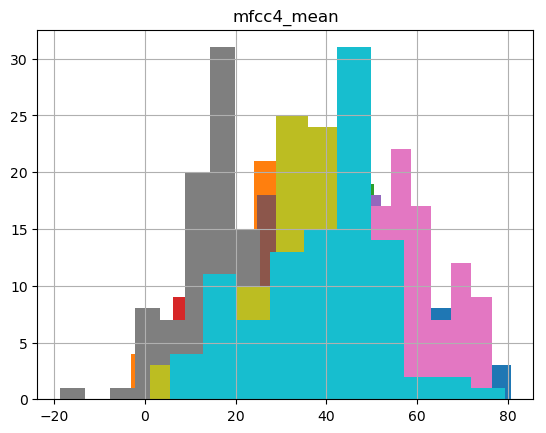

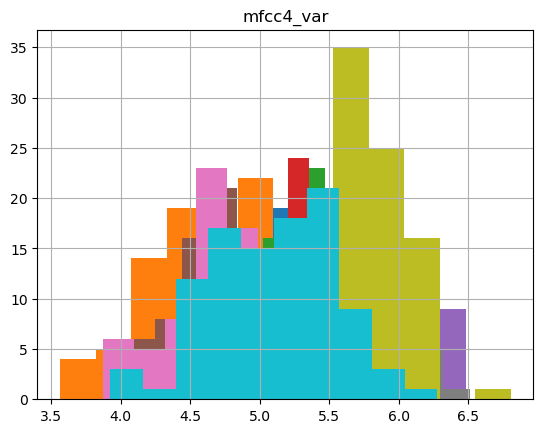

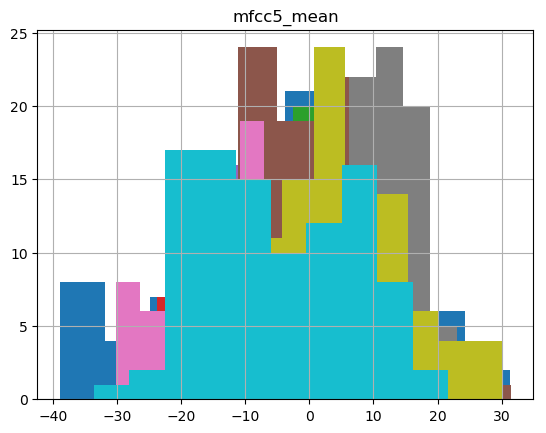

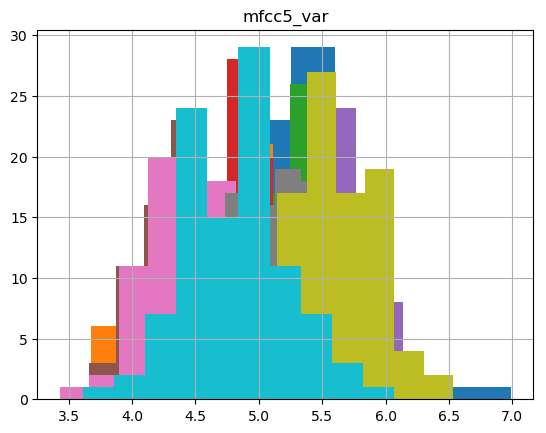

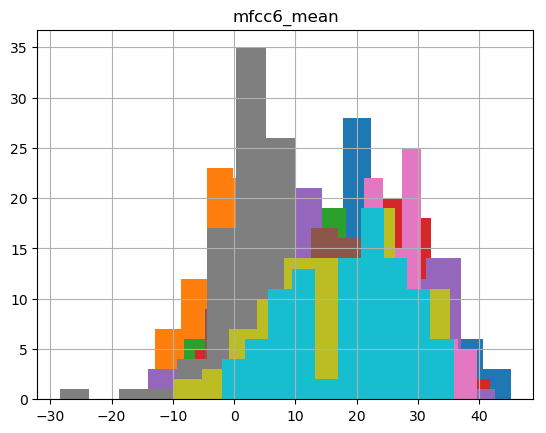

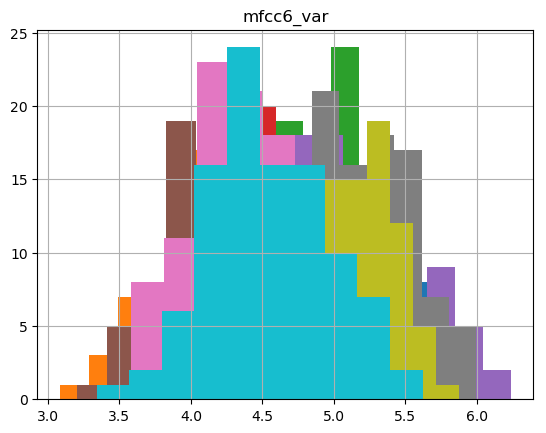

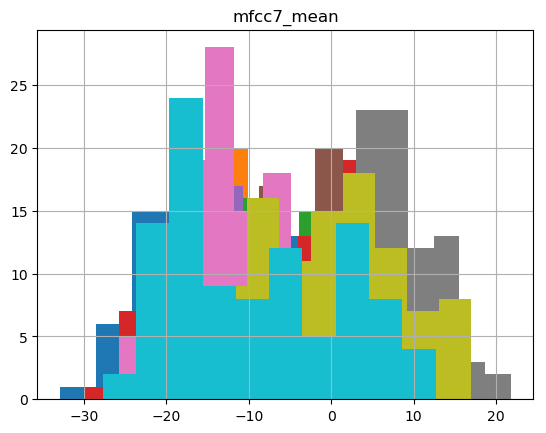

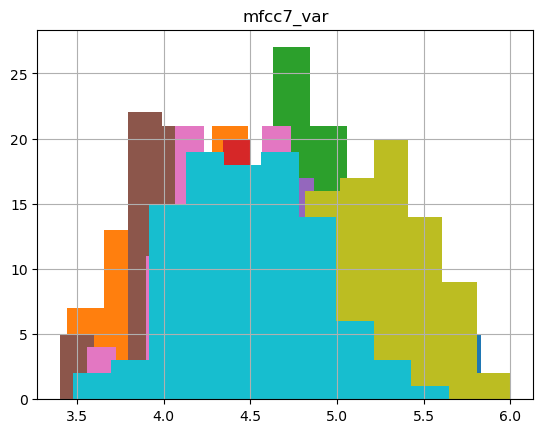

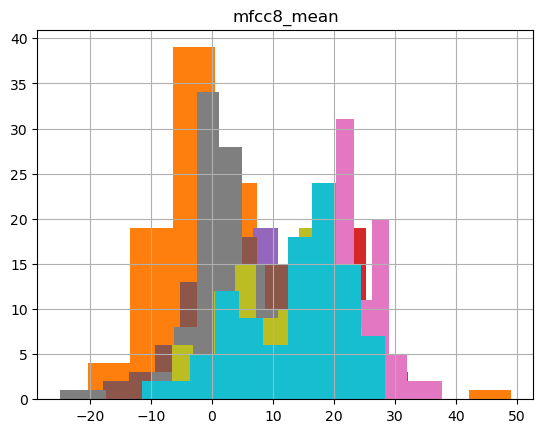

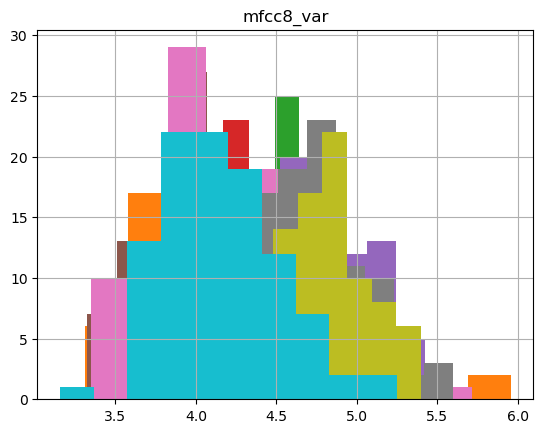

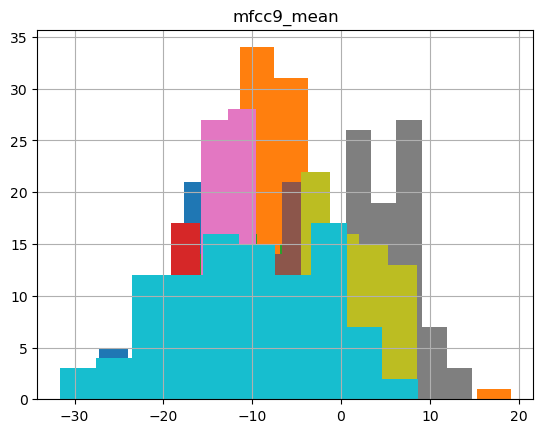

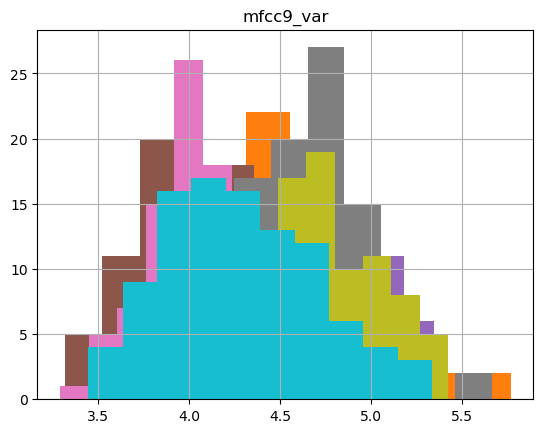

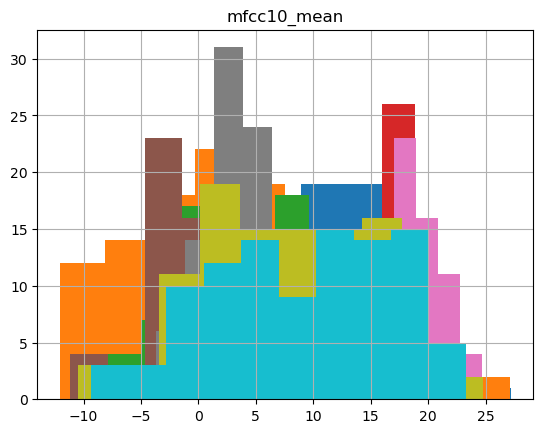

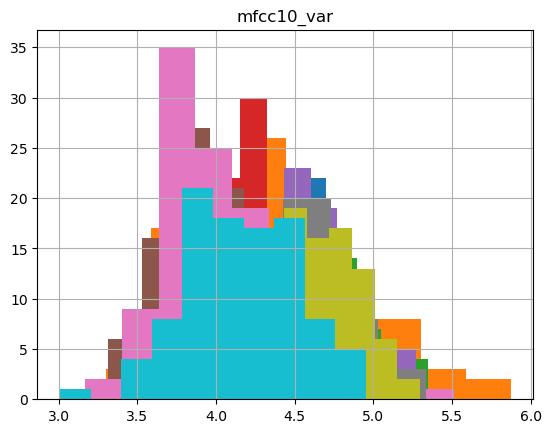

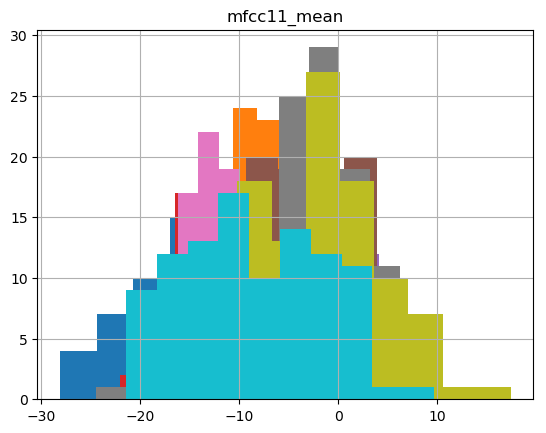

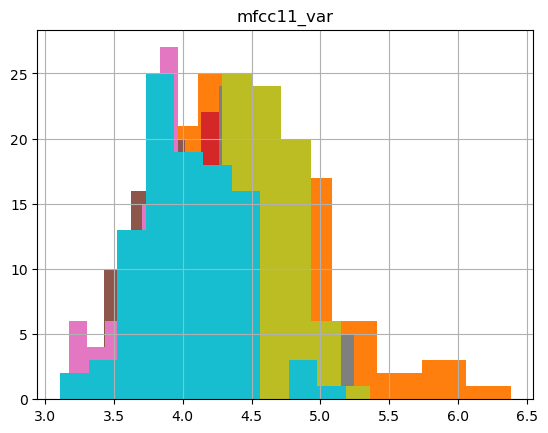

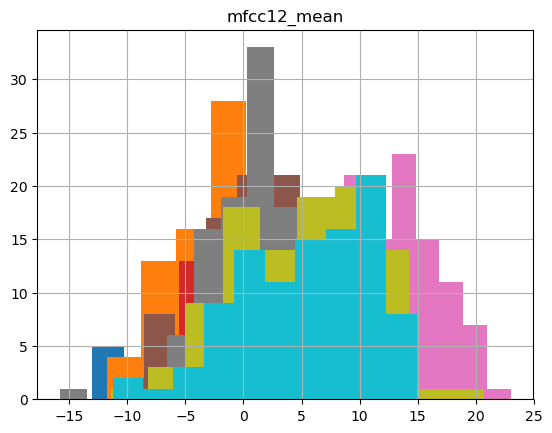

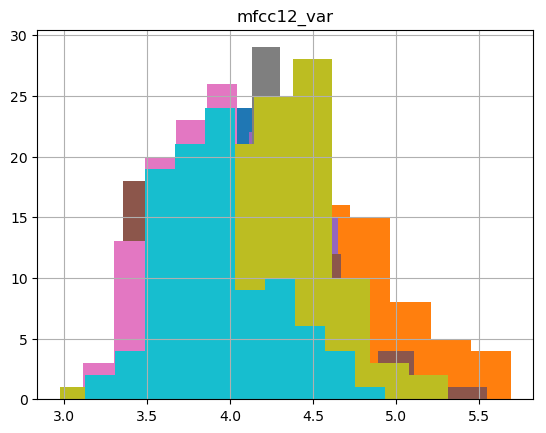

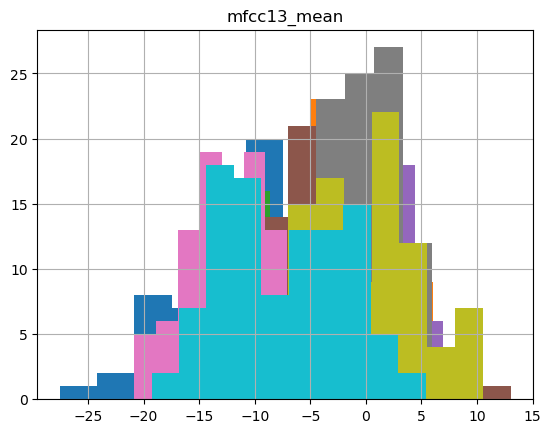

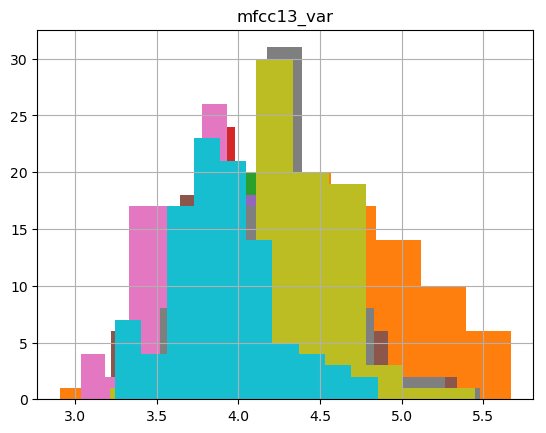

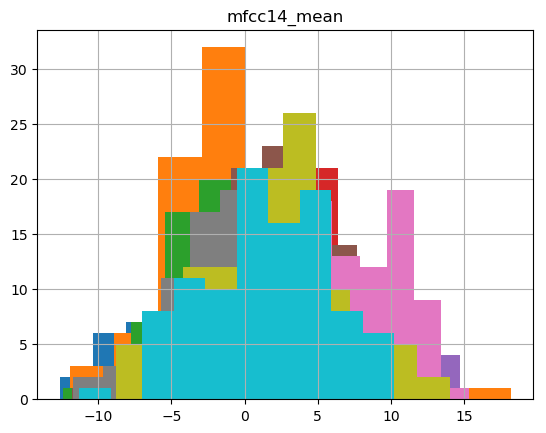

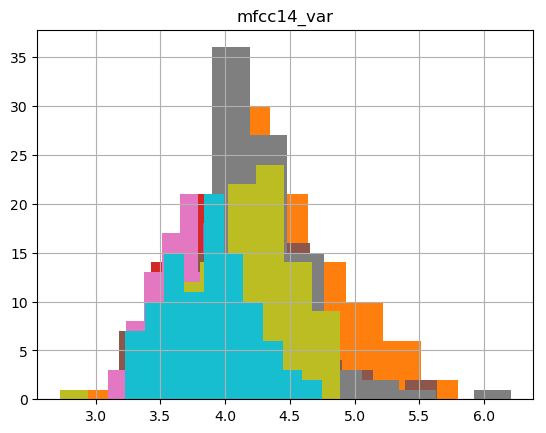

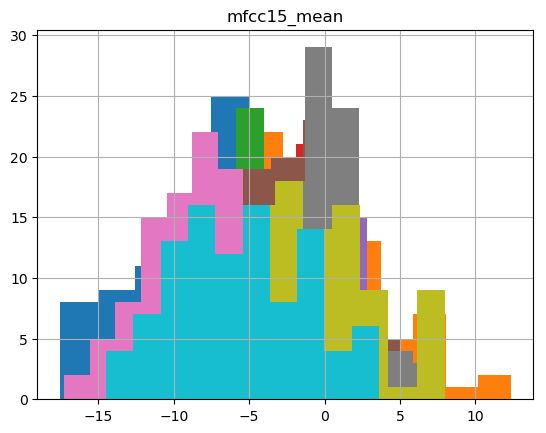

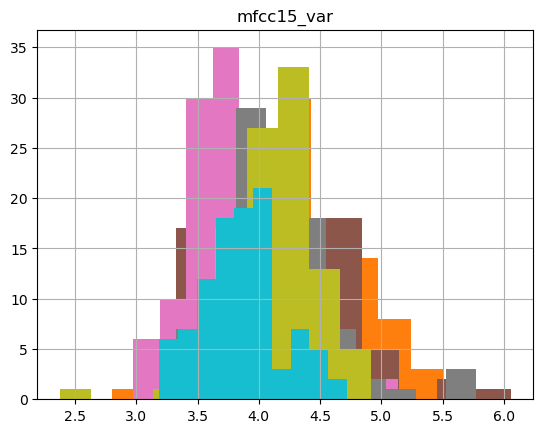

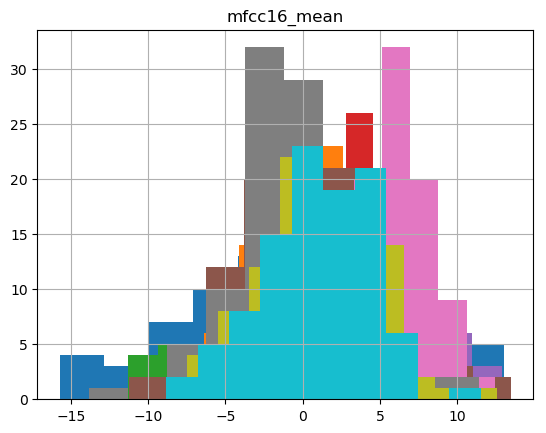

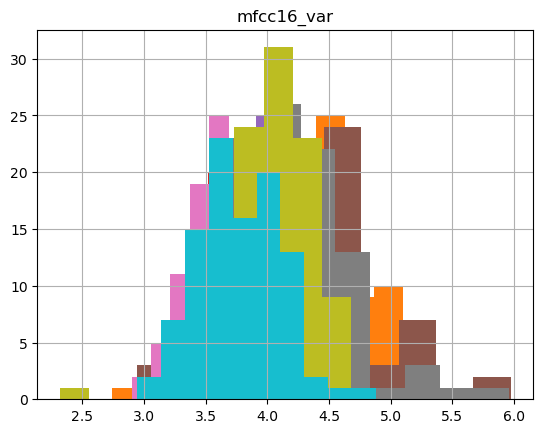

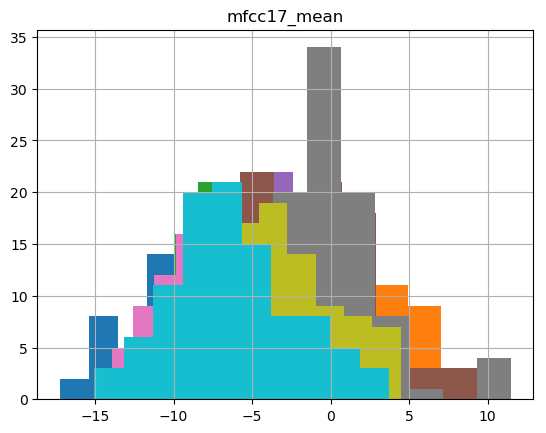

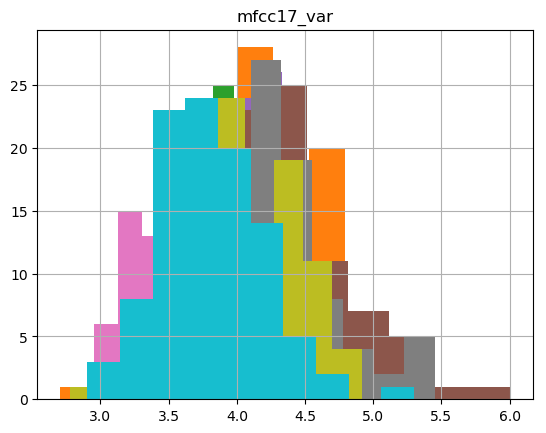

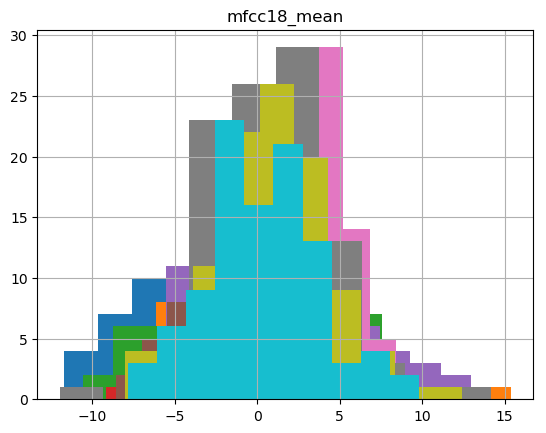

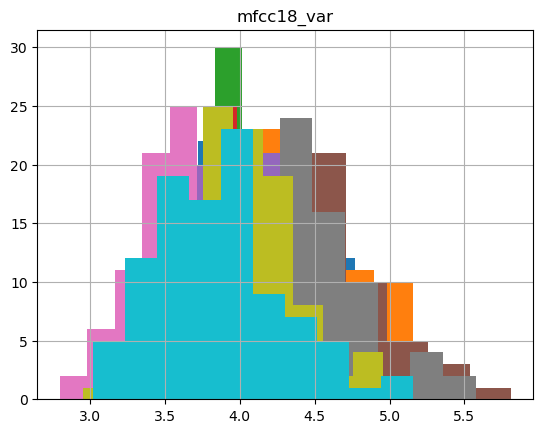

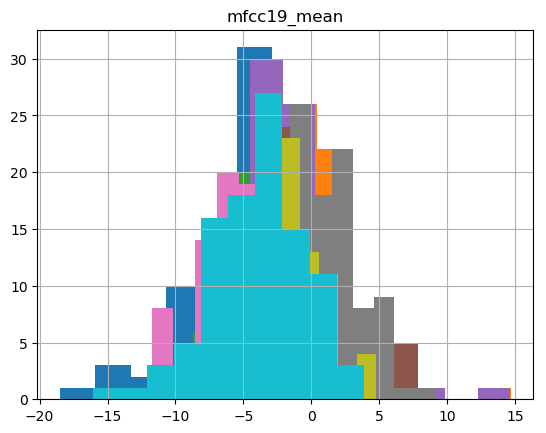

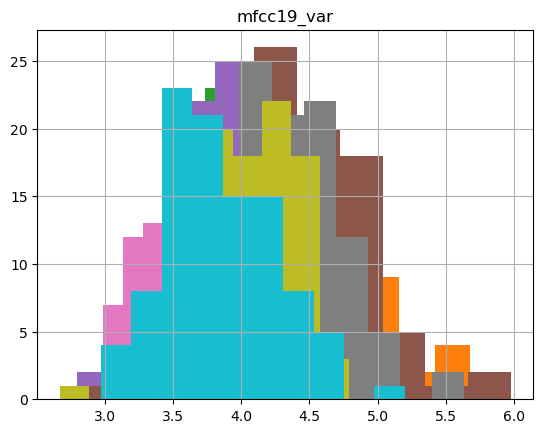

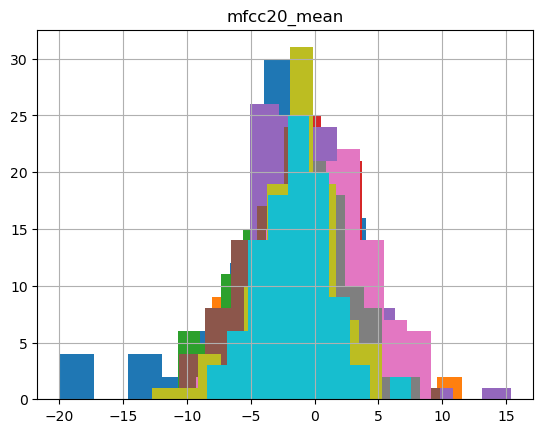

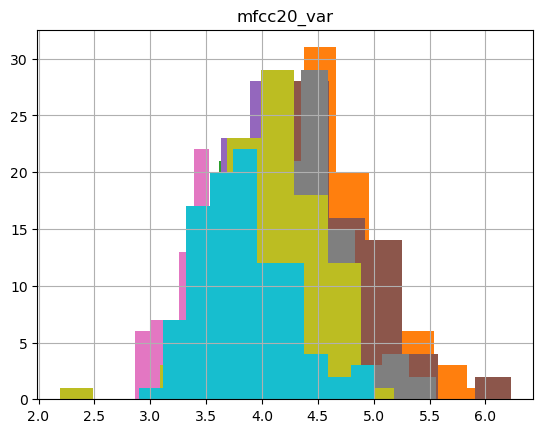

In [10]:
with plt.rc_context(rc={'figure.max_open_warning': 0}): 
    for feat in X_data.columns:
        plt.figure()
        Xy[feat].hist()
        plt.title(feat)

We see that our var features are mostly now normaly distributed. We can now standardize our data.

In [11]:
X_data_clean = pd.DataFrame(StandardScaler().fit_transform(X_data),columns=X_data.columns)

let's boxplot some features that we can interpret like RMSe, zero-crossing rate, tempo, harmony, spectral centroid and perceptrual  
Then we can plot our features against each other in a correlation matrix heatmap.

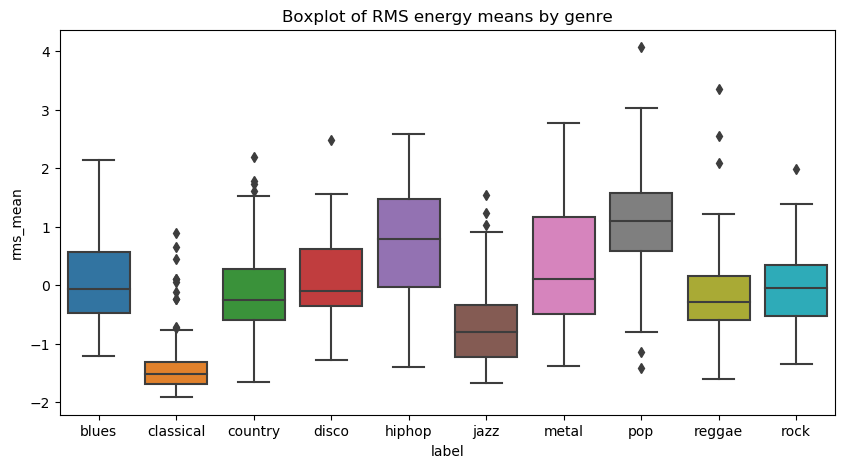

In [12]:
plt.figure(figsize=(10,5))
sns.boxplot(x=labels,y=X_data_clean.rms_mean,orient="v")
plt.title("Boxplot of RMS energy means by genre");

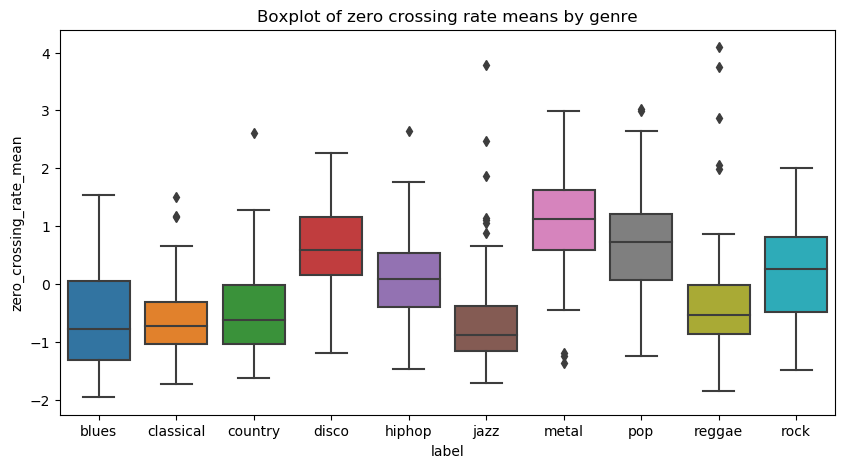

In [13]:
plt.figure(figsize=(10,5))
sns.boxplot(x=labels,y=X_data_clean.zero_crossing_rate_mean,orient="v")
plt.title("Boxplot of zero crossing rate means by genre");

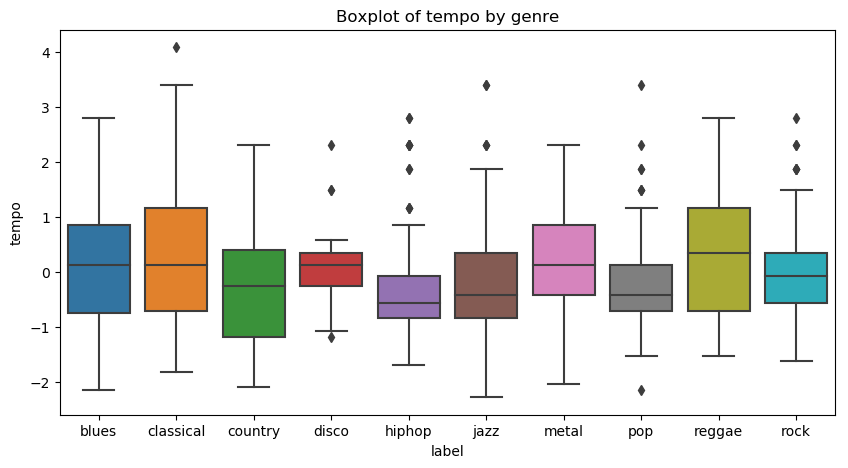

In [14]:
plt.figure(figsize=(10,5))
sns.boxplot(x=labels,y=X_data_clean.tempo,orient="v")
plt.title("Boxplot of tempo by genre");

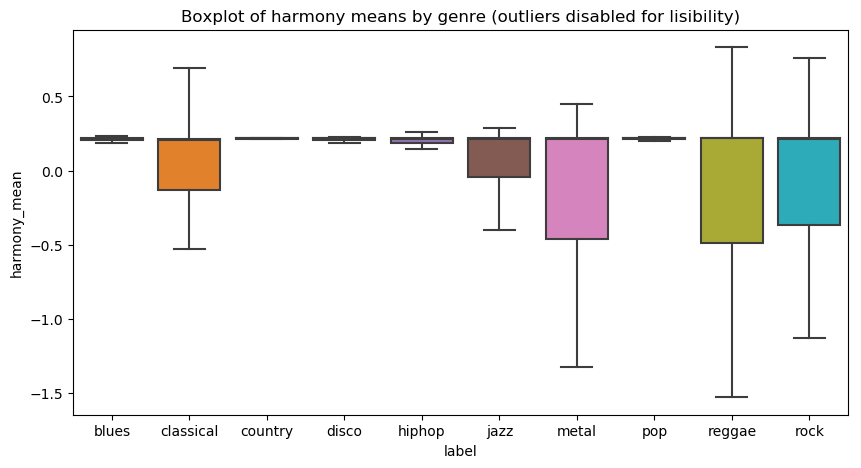

In [15]:
plt.figure(figsize=(10,5))
sns.boxplot(x=labels,y=X_data_clean.harmony_mean,orient="v",showfliers=False)
plt.title("Boxplot of harmony means by genre (outliers disabled for lisibility)");

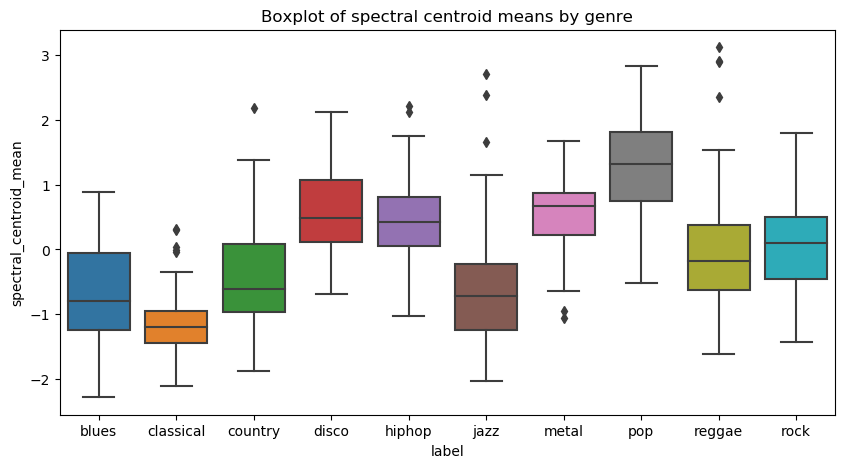

In [16]:
plt.figure(figsize=(10,5))
sns.boxplot(x=labels,y=X_data_clean.spectral_centroid_mean,orient="v")
plt.title("Boxplot of spectral centroid means by genre");

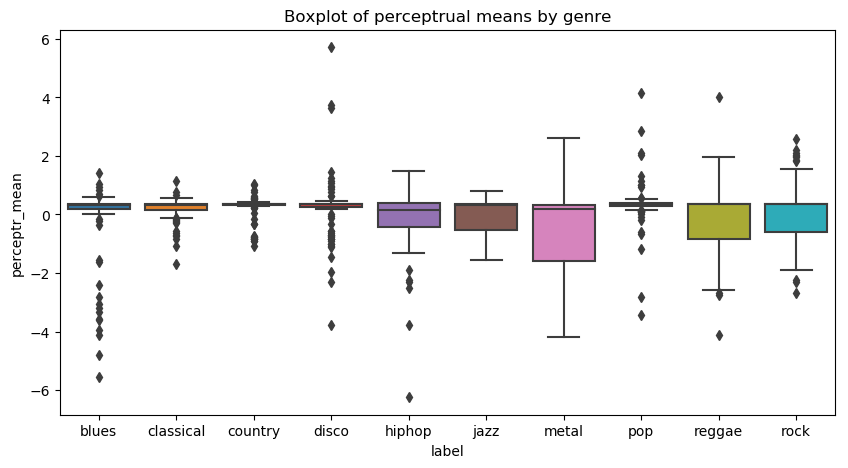

In [17]:
plt.figure(figsize=(10,5))
sns.boxplot(x=labels,y=X_data_clean.perceptr_mean,orient="v")
plt.title("Boxplot of perceptrual means by genre");

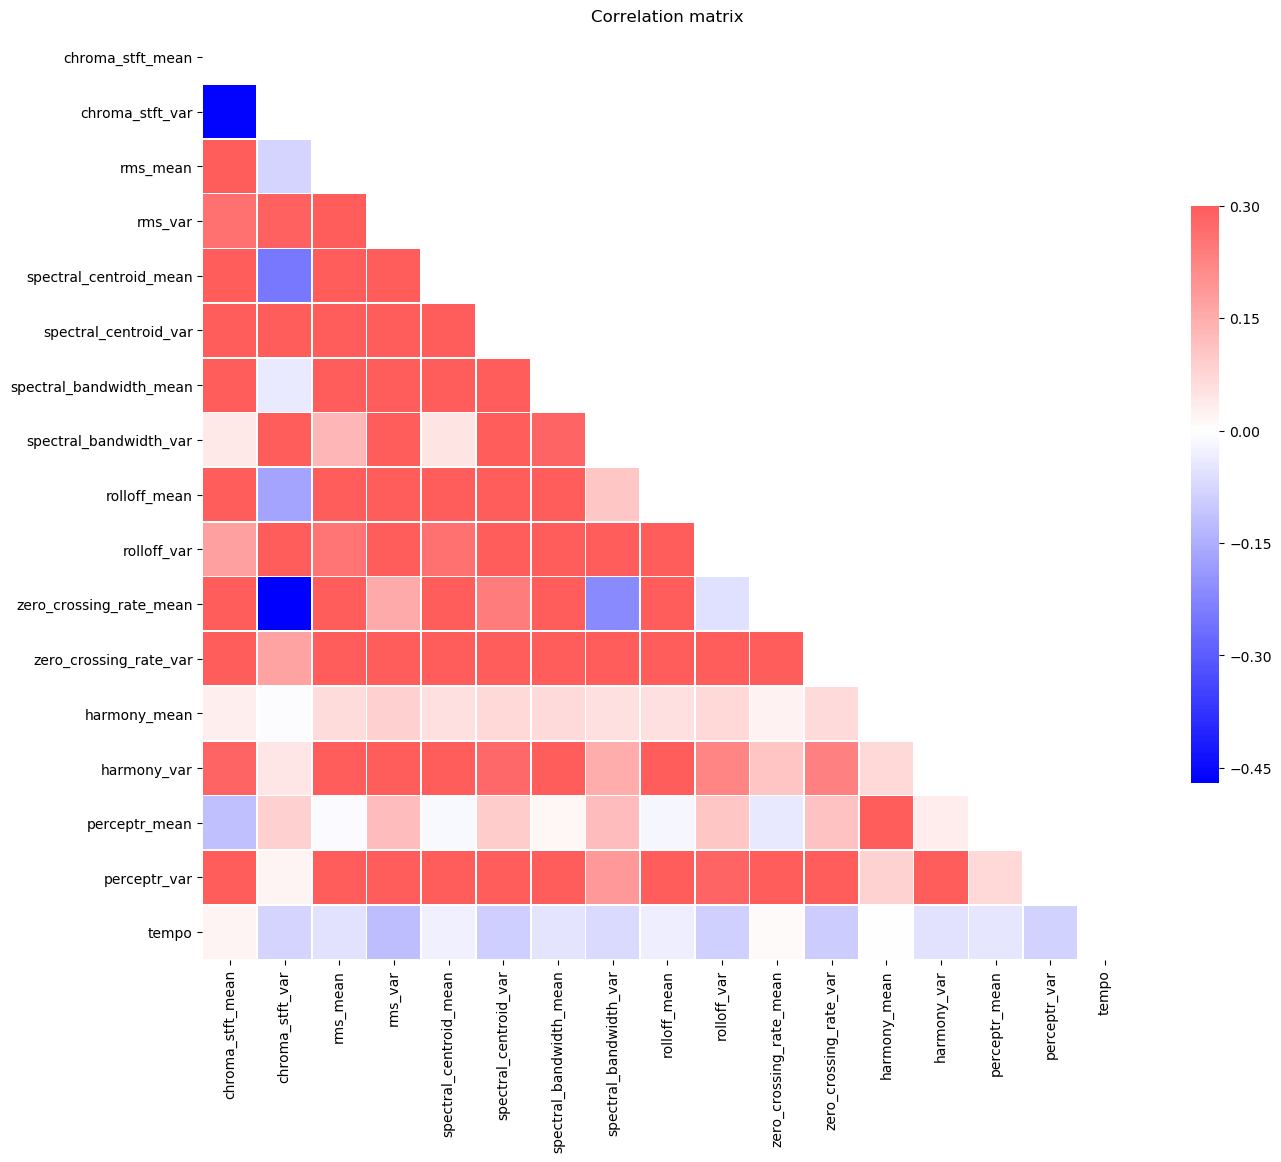

In [18]:
corr = X_data_clean.iloc[:,:17].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr, mask=mask, cmap="bwr", vmax=.3, center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.5})
plt.title("Correlation matrix");

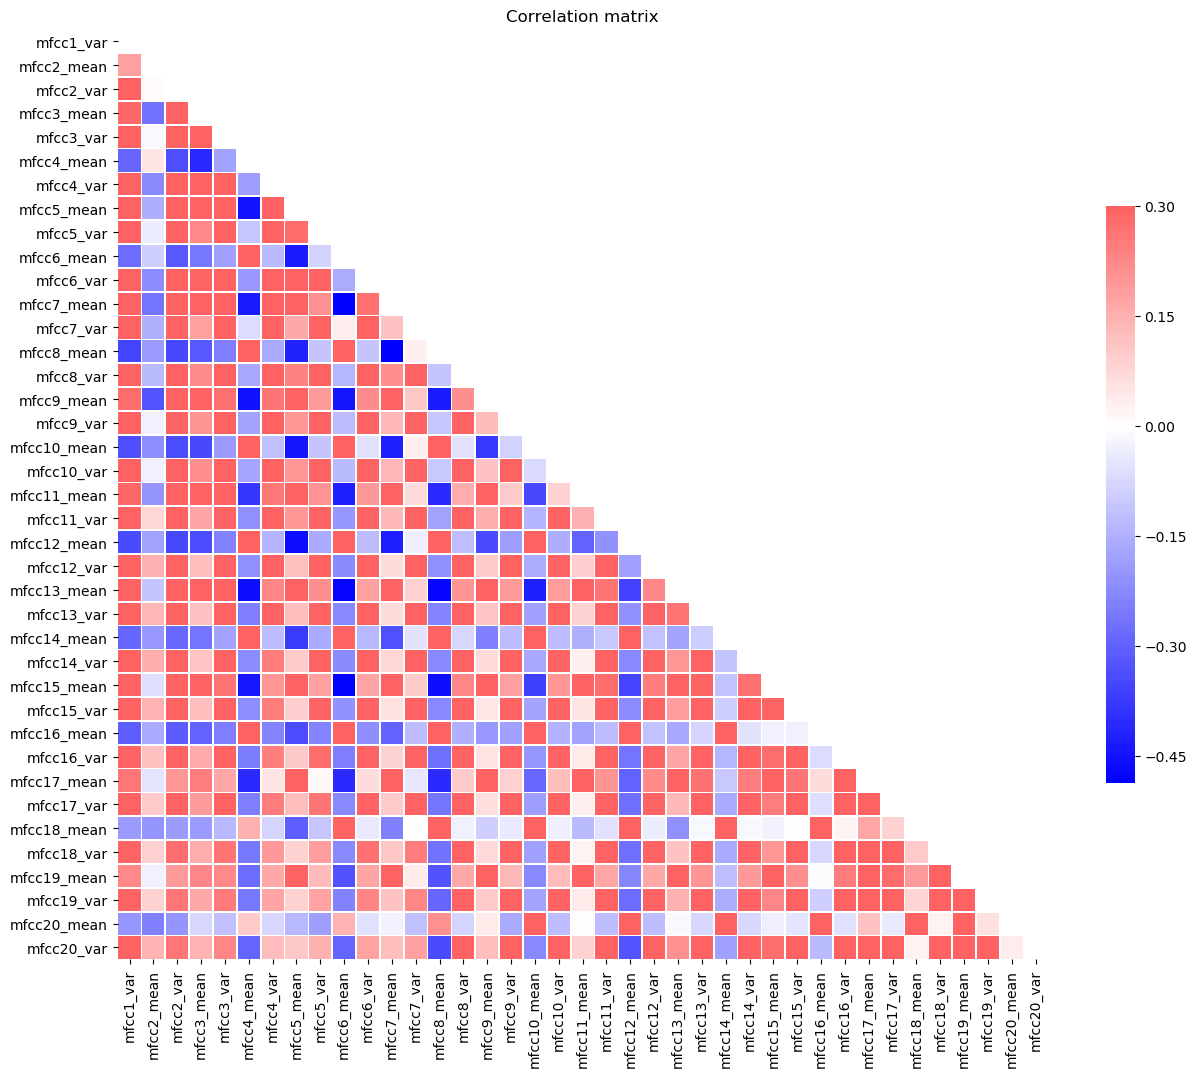

In [19]:
corr2 = X_data_clean.iloc[:,18:].corr()
mask = np.triu(np.ones_like(corr2, dtype=bool))
f, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr2, mask=mask, cmap="bwr", vmax=.3, center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.5})
plt.title("Correlation matrix");

We see in the RMS energy distribution by genre loudness of the sound. We see here that hiphop, metal and pop tend to have loud music, whereas classical and jazz music are more calm. We see that pop has a wide range of loudness. I would think this translates how pop music can be a lot of things at the same time, there can be as many slow music as energetic and loud music.

In the zero crossing rate distribution by genre boxplot, we can see that metal, pop, disco and rock have lots of percussions in their sound, these music genre tend to be more energetic in percussions than other like jazz or blues in general. Blues and jazz music usually has few to no percussion instruments and metal and rock have drum sets. However we see some outliers, for example, in jazz, I know there can be some contemporary jazz style music that uses drums more than classical jazz standards. In raggae too, there are some very energetic subgenres of the style like dub that will be categorised as raggae while having more percussion than the slow raggae standards we usually think of.

We see on the distribution of tempo by genre boxplot that tempo in general is between 100 and 150 bpm. We see that in disco, hiphop, pop and rock, the tempo is distributed close around their mean. In classical music howerer it's wider, we know that the classical genre has tempo classification from *lento* (slow) to *allegro* (fast) so it's normal to have a wide panel of tempo.

In the harmony means distribution we can see that blues, country, disco, hiphop, and pop have close to no complexity in harmony. For example, most of pop songs nowadays follow some basic chord progressions that are very mainstream and sound naturally well due to very good harmony. Whereas rock or jazz music have complexities in their music with out of key notes here and there by jumping between modes to create tension, therefore indicating negative values in harmonies.

We see in the distribution of spectral centroids means by genre that pop, metal, hiphop and disco tend to have a brighter sound overall than the other extremes : classical, jazz and blues. This is probably due to brighter instruments like electric guitar in metal and pop, and in the extremes we have some lower instruments like cello or bass, or even lower voices like in blues and country. Maybe its the electric bass in rock music that lowers the higher electric guitar sound ?

In the perceptrual boxplots, we see that the boxes that are wider are the same as the harmony. It makes sense because tension due to negative harmony influences emotion.

As for the correlation matrices, we see that the correlation go from -0.45 to 0.30, there are no features highly correlated with another. We see that first numbers of MFCCs are least correlated with the last numbers of MFCCs. I've done some research and found that first numbers of MFCCs are associated with the caracteristics of the music whereas the last ones are more into speech caracteristics.

I can see that in the boxplots I made, we can already differentiate some genre and give insights, some features make these genre close to each other in different ways and it's interesting to see. So it's encouraging for the project to see that we can already visualise easily differences from lower level features so we can hope that the MFCCs and spectrogram would inform our algorithms well. 

We see that the the dimensionality is high, let's explore with PCA

In [20]:
pcafull = pca()

In [21]:
pcafull.fit_transform(X_data_clean);

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [57] columns of the input data.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Number of components is [32] that covers the [95.00%] explained variance.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[5]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


Let's make a screeplot of the cumulative explained variance :

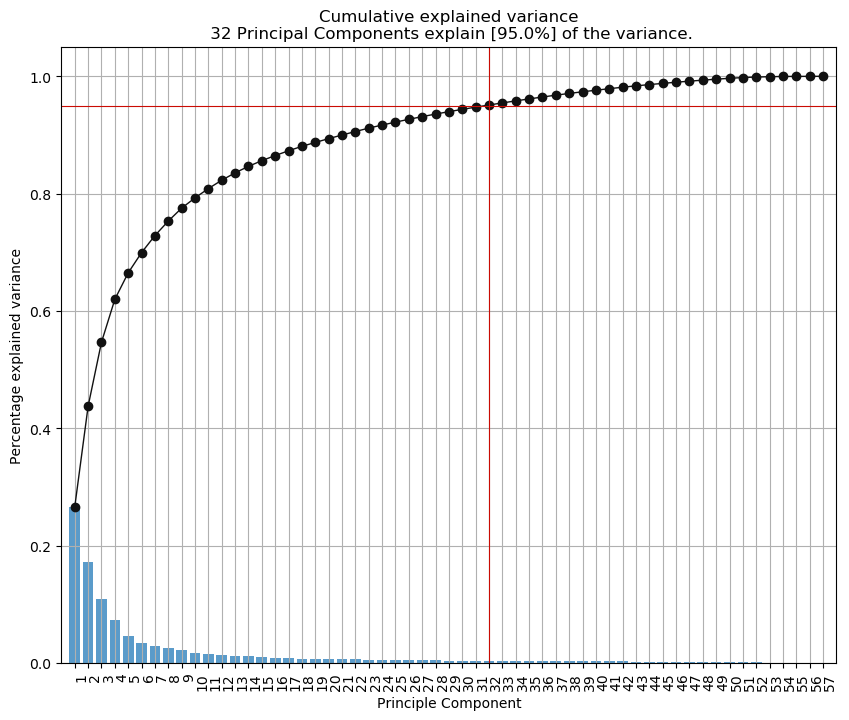

<Figure size 640x480 with 0 Axes>

In [22]:
pcafull.plot();

We see in this plot the importance of how many features we can keep to keep a good amount of information, here for instance we need 33 first components to explain 95% of our data, however this still seems much and doesn't feel like a good deal, so I'll check visually where I feel there is an "elbow" in the cumulative curve. I see it starts at 5 components, and I see it already explains around 63% of our 57 components so I feel ok with that. Let's now see with 2 components and a biplot. We can start by seeing what features explain more our first 2 components :

In [23]:
pca2d = pca(n_components=2)

In [24]:
results_pca = pca2d.fit_transform(X_data_clean)

[pca] >Processing dataframe..
[pca] >The PCA reduction is performed on the [57] columns of the input dataframe.
[pca] >Fitting using PCA..
[pca] >Computing loadings and PCs..
[pca] >Computing explained variance..
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[2]
[pca] >Outlier detection using SPE/DmodX with n_std=[2]


Let's see which are the most usefull features :

In [25]:
results_pca["topfeat"]

PC                  feature   loading  type
0   PC1                mfcc2_var -0.190821  best
1   PC2             rolloff_mean  0.278821  best
2   PC2         chroma_stft_mean  0.245829  weak
3   PC1          chroma_stft_var -0.180613  weak
4   PC2                 rms_mean  0.233177  weak
5   PC2                  rms_var  0.179505  weak
6   PC2   spectral_centroid_mean  0.273341  weak
7   PC2    spectral_centroid_var  0.221437  weak
8   PC2  spectral_bandwidth_mean  0.277575  weak
9   PC1   spectral_bandwidth_var -0.161975  weak
10  PC2              rolloff_var  0.159872  weak
11  PC2  zero_crossing_rate_mean  0.199807  weak
12  PC2   zero_crossing_rate_var  0.209764  weak
13  PC2             harmony_mean  0.027722  weak
14  PC2              harmony_var  0.175215  weak
15  PC1            perceptr_mean -0.055902  weak
16  PC2             perceptr_var  0.227889  weak
17  PC1                    tempo  0.023913  weak
18  PC2               mfcc1_mean  0.248120  weak
19  PC1                mfcc1_var -0.185927  weak
20  PC2               mfcc2_mean -0.268347  weak
21  PC1               mfcc3_mean -0.130512  weak
22  PC1                mfcc3_var -0.169221  weak
23  PC1               mfcc4_mean  0.137108  weak
24  PC1                mfcc4_var -0.160941  weak
25  PC1               mfcc5_mean -0.145043  weak
26  PC1                mfcc5_var -0.165767  weak
27  PC1               mfcc6_mean  0.133797  weak
28  PC1                mfcc6_var -0.170167  weak
29  PC1               mfcc7_mean -0.136141  weak
30  PC1                mfcc7_var -0.151452  weak
31  PC1               mfcc8_mean  0.142038  weak
32  PC1                mfcc8_var -0.179639  weak
33  PC2               mfcc9_mean  0.132155  weak
34  PC1                mfcc9_var -0.178738  weak
35  PC1              mfcc10_mean  0.125997  weak
36  PC1               mfcc10_var -0.178912  weak
37  PC1              mfcc11_mean -0.116575  weak
38  PC1               mfcc11_var -0.185772  weak
39  PC1              mfcc12_mean  0.140460  weak
40  PC1               mfcc12_var -0.176482  weak
41  PC1              mfcc13_mean -0.142240  weak
42  PC1               mfcc13_var -0.178373  weak
43  PC1              mfcc14_mean  0.106754  weak
44  PC1               mfcc14_var -0.169536  weak
45  PC1              mfcc15_mean -0.139513  weak
46  PC1               mfcc15_var -0.166697  weak
47  PC1              mfcc16_mean  0.103273  weak
48  PC1               mfcc16_var -0.165904  weak
49  PC1              mfcc17_mean -0.110792  weak
50  PC1               mfcc17_var -0.164225  weak
51  PC1              mfcc18_mean  0.055978  weak
52  PC1               mfcc18_var -0.152934  weak
53  PC1              mfcc19_mean -0.102703  weak
54  PC1               mfcc19_var -0.152570  weak
55  PC2              mfcc20_mean  0.067768  weak
56  PC1               mfcc20_var -0.154321  weak

We can see that the best feature for component 1 is mfcc_var and component 2 is rolloff_mean, they represent . We also see that majority of component 1 consists of mfcc values. I've been thinking of removing the variance part of the features as they seemed overkill somehow, but seeing that some variance features contribute a lot, I will keep them. 
Let's now do our biplot :

In [26]:
classes = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz',
       'metal', 'pop', 'reggae', 'rock']

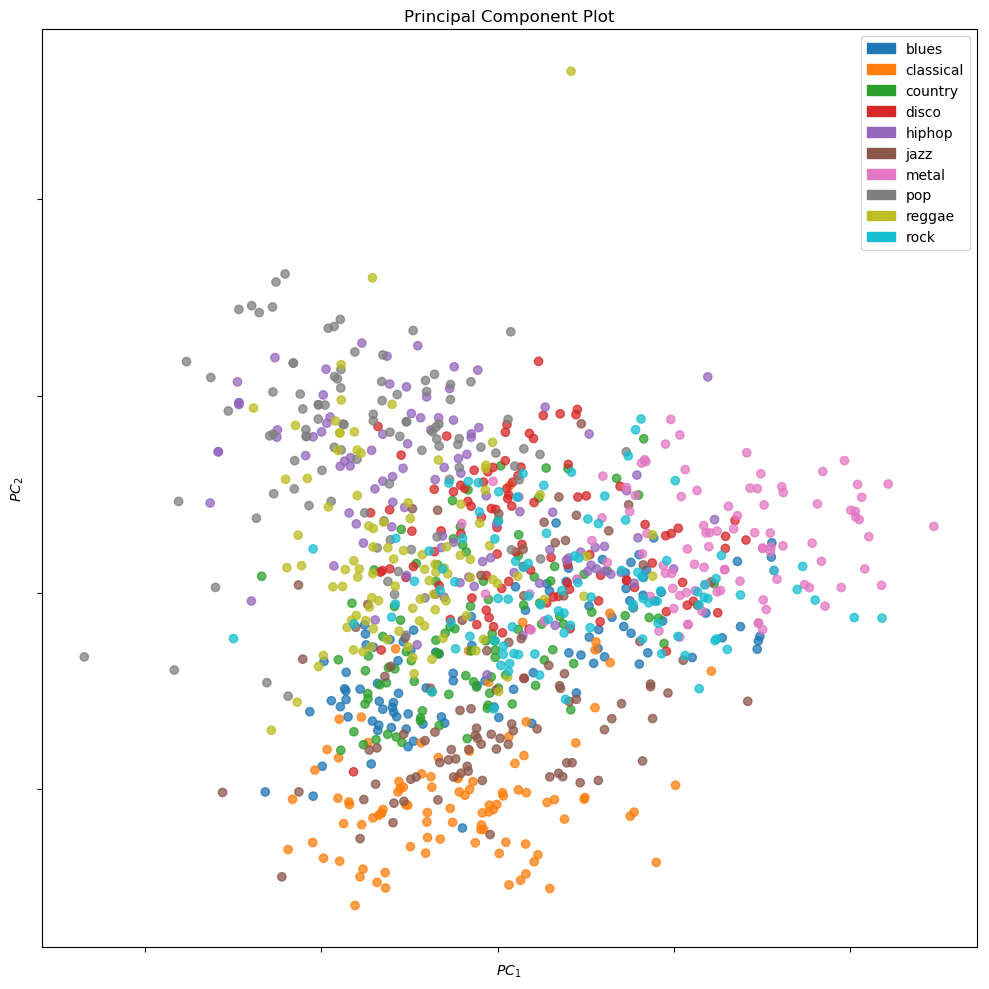

In [27]:
plt.figure(figsize=(10,10))
visualizer = PCA(classes=classes,colormap="tab10")
visualizer.fit_transform_show(X_data_clean,y);

We can already see some clusters forming, we can see what genres are similar if their clusters are in the same zone. We see similarities between metal and rock on the right, same with jazz and classical on the down side. I already see there might be problems to classify rock later on as it widely spread among others.

Let's now do this feature selection exercice but with UMAP :

In [28]:
umap2d = UMAP()

In [29]:
projections = umap2d.fit(X_data_clean)

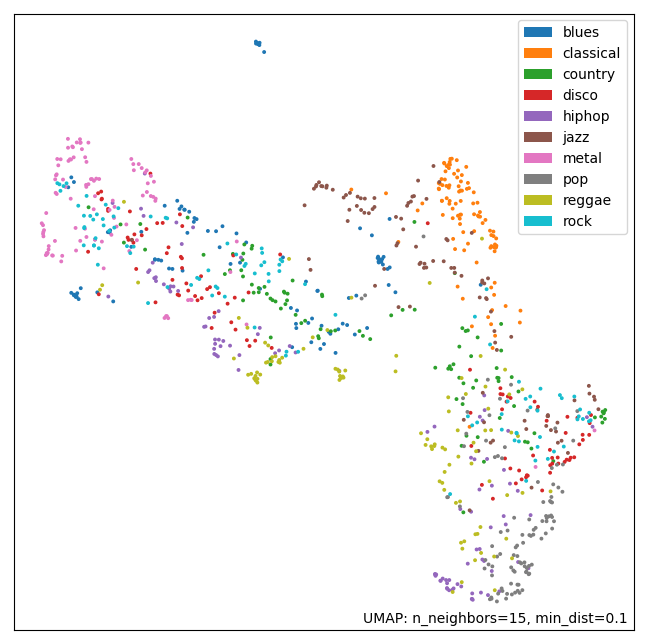

In [30]:
umap.plot.points(projections,labels=labels,color_key_cmap="tab10");

We see that with UMAP the clusters are mostly organised on the same zones than PCA but mirrored by 180° rotation. We see that in PCA the clusters are closer to each other but in UMAP they are more spaced out. Anyway, the component projection results are similar in both cases.  We can also note that rock, disco and country are very wide from left to right, it can already show here again that for example rock might be hard to correctly classify as it is similar to other genres it shares its cluster, whereas genres like classical or metal are well defined. 

Let's now see our mel spectrogram images, we can see 3 examples of each class :

/Users/jasonola/opt/anaconda3/envs/exts-ml/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


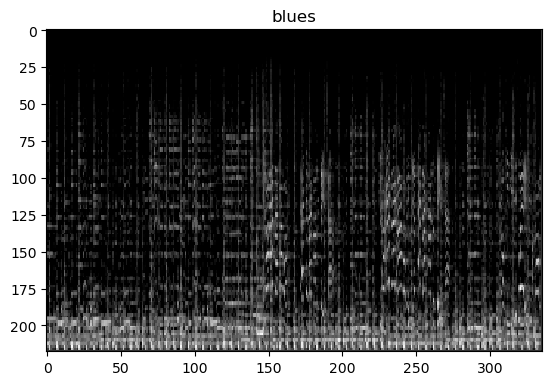

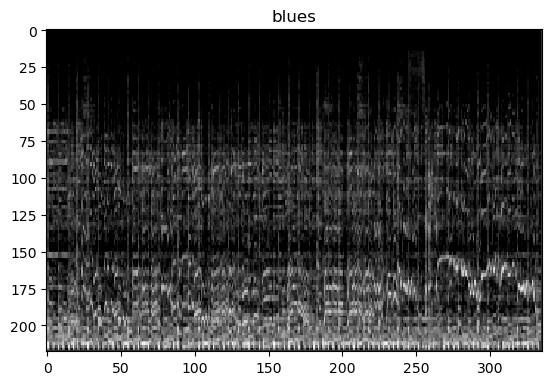

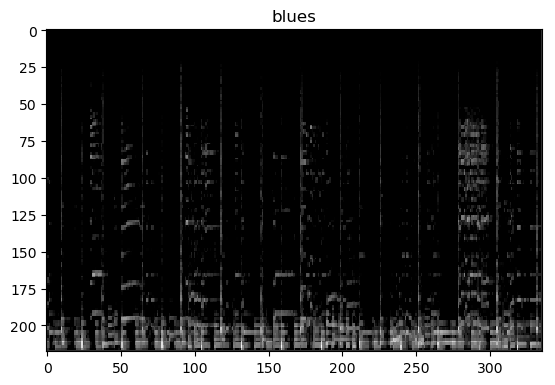

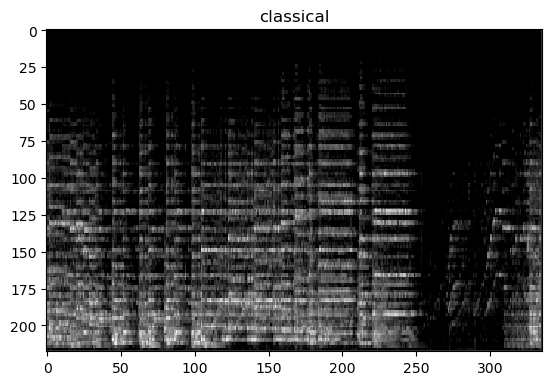

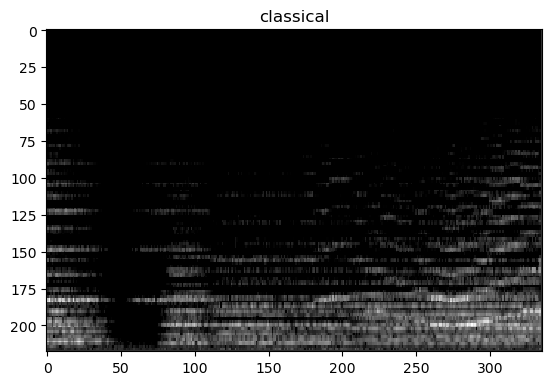

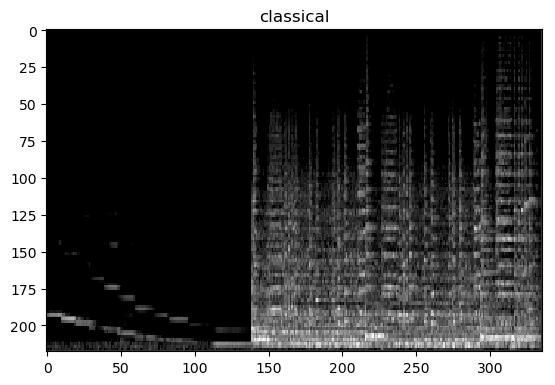

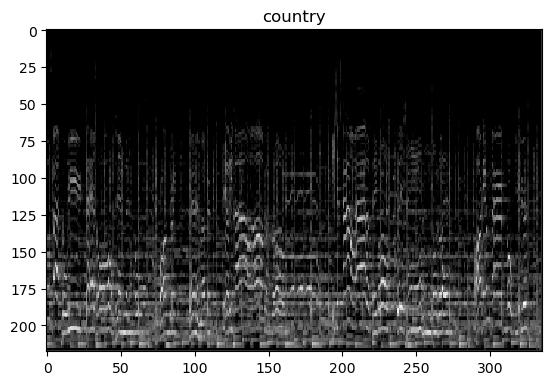

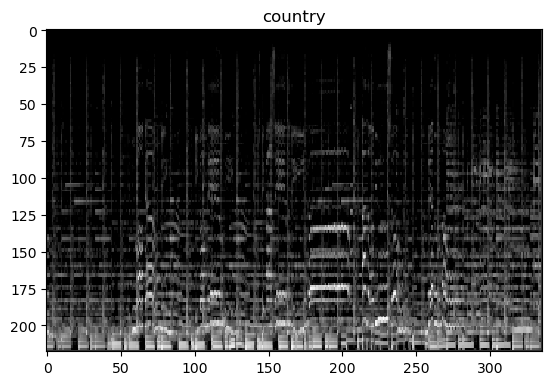

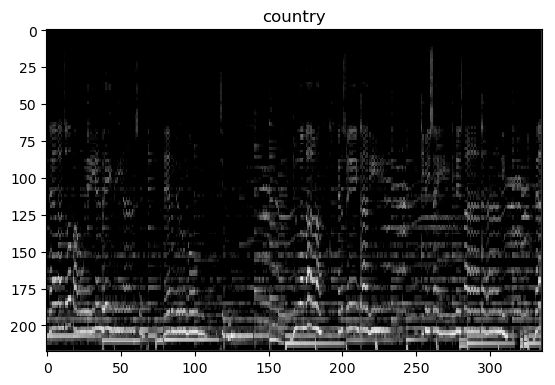

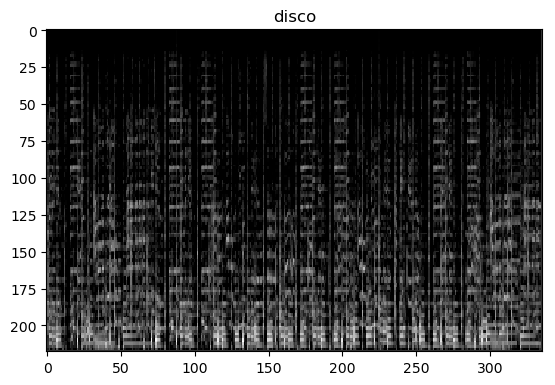

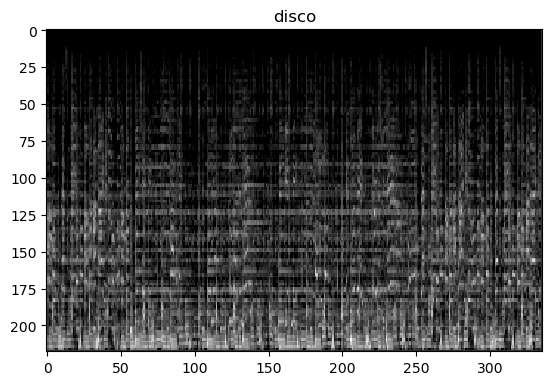

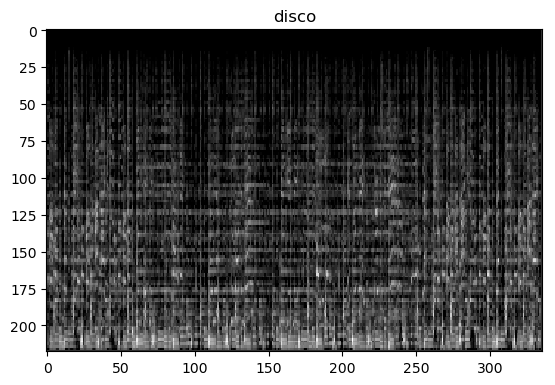

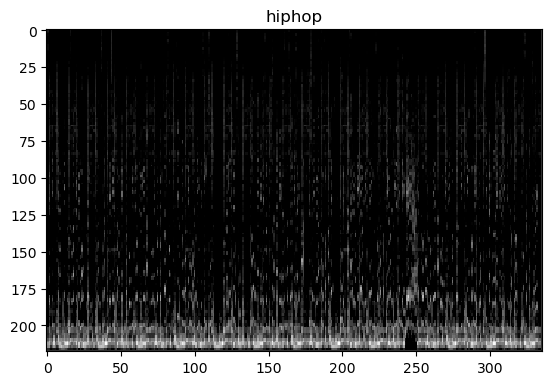

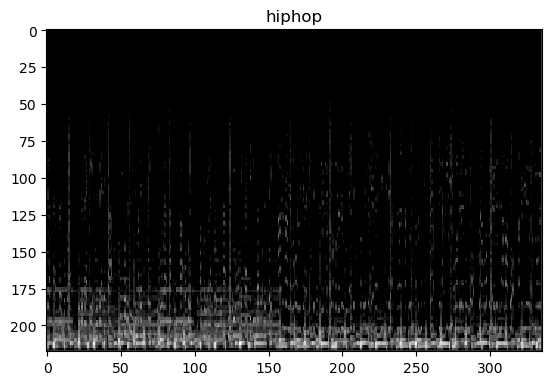

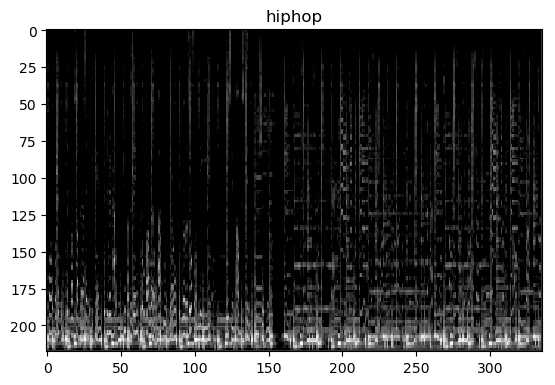

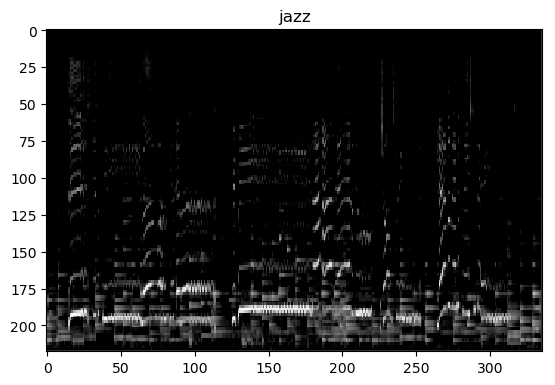

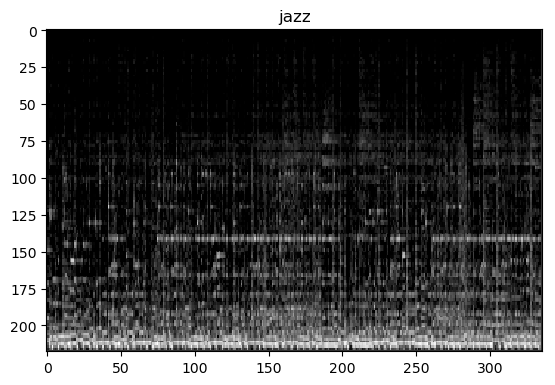

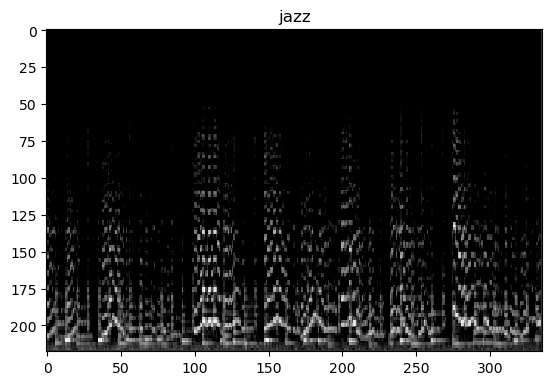

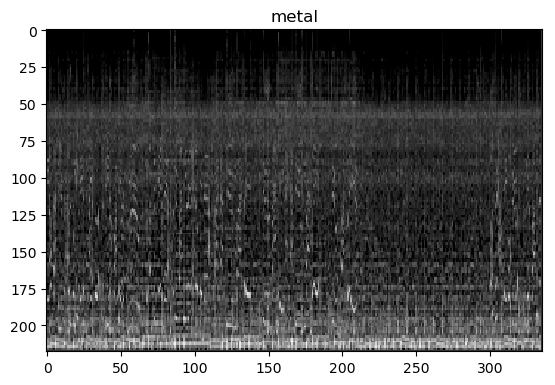

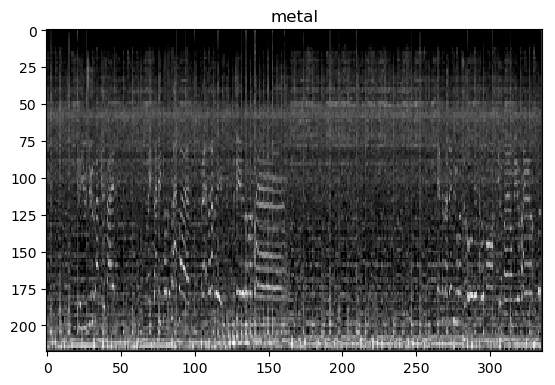

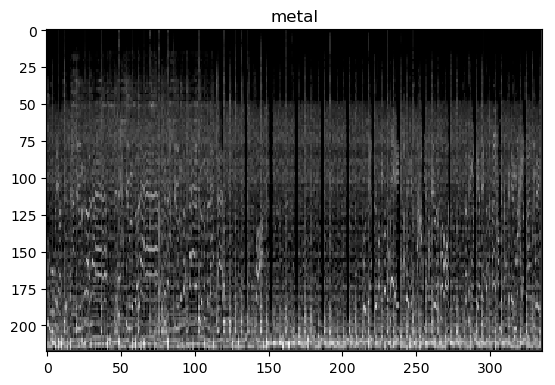

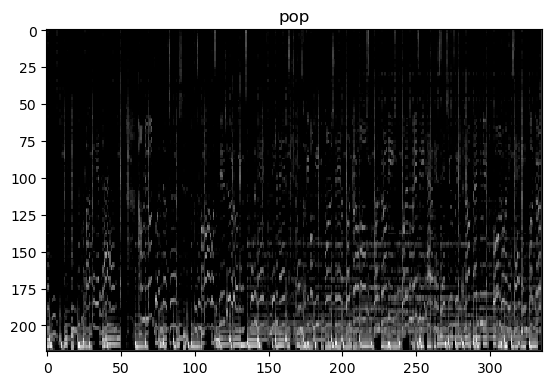

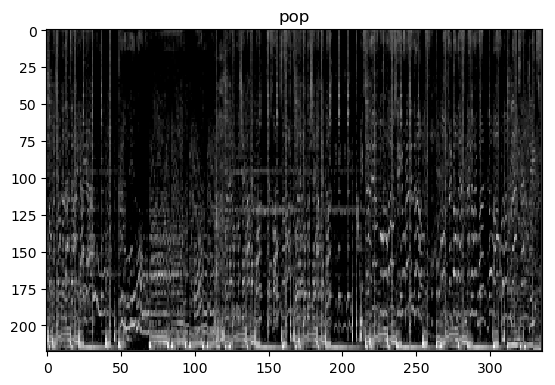

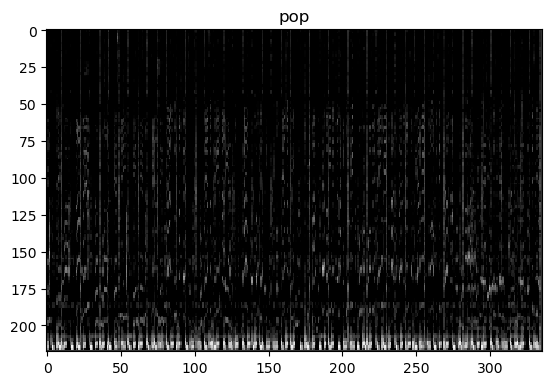

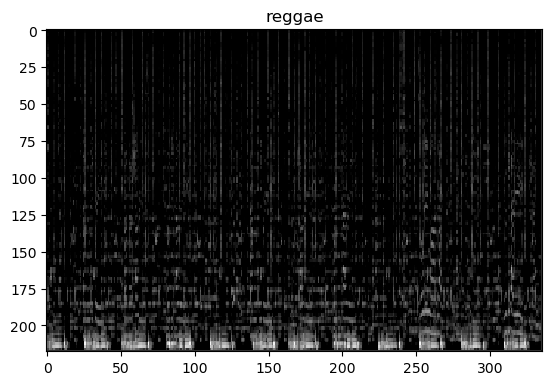

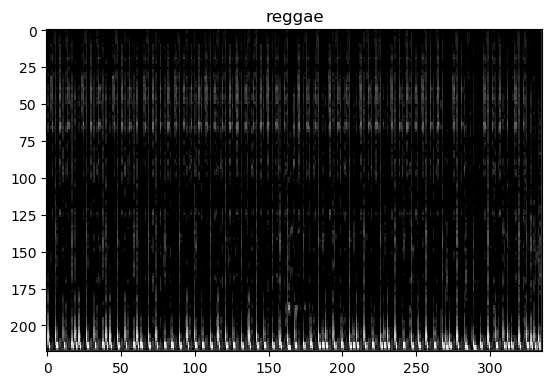

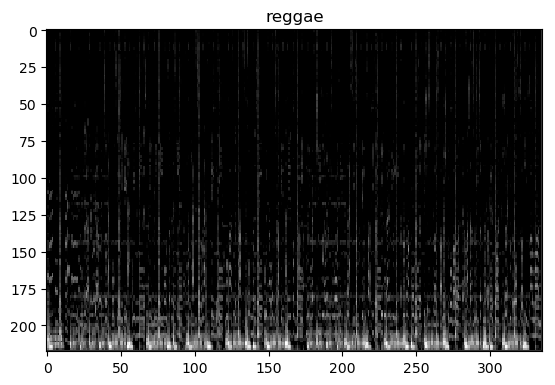

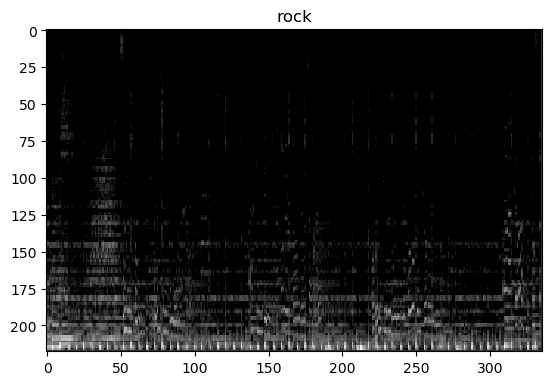

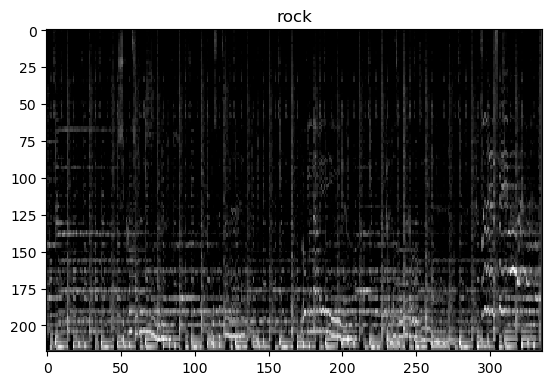

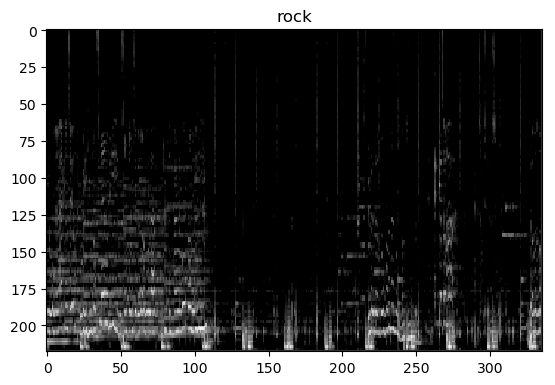

In [31]:
for i in range(10):
    for j in range(3):
        plt.figure()
        plt.imshow(X_img_clean[i*100+50+j],cmap=plt.cm.gray)
        plt.title(labels.unique()[i])      

We can see some similarities in some genres like metal where the spectrogram is saturated with white, which shows high pitch throughout the song. In reggae and hip hop we see the percussion with rythmic visual patterns. But we also see differences like in blues where we can see a high pitched song and another one is lower. We can also see there is a classical song that is particular, it begins low but at a third of the song it is higher.

Let's now store our cleaned data :

In [32]:
%store X_data_clean

Stored 'X_data_clean' (DataFrame)
